# Hurricane Track Prediction - Visualization Suite

visualizations for the Kalman Filter hurricane track prediction project.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
FIG_SIZE = (10, 6)
DPI = 300
SAVE_DIR = 'figures/'

import os
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:
# Load processed dataset
df = pd.read_pickle("data/hurricane_paths_processed.pkl")
df = df.sort_values(['sid', 'iso_time']).reset_index(drop=True)

print(f"Loaded {len(df):,} observations from {df['sid'].nunique():,} storms")


Loaded 721,960 observations from 13,450 storms


## Results

In [19]:
def plot_forecast_error_vs_leadtime(rmse_results_baseline=None, rmse_results_adaptive=None, 
                                     save_path=None):
    """
    Plot RMSE vs lead time for baseline and adaptive KF models
    
    Args:
        rmse_results_baseline: Dict or DataFrame with lead times and RMSE values
                              Format: {'lead_times': [6, 12, 24, 48, 72], 'rmse': [15.86, 34.50, ...]}
        rmse_results_adaptive: Same format for adaptive model
        save_path: Path to save figure
    """
    
    # Default example data (replace with actual results)
    if rmse_results_baseline is None:
        print("Using example data. Replace with actual results from KF evaluation.")
        rmse_results_baseline = {
            'lead_times': [6, 12, 24, 48, 72],
            'rmse': [15.86, 34.50, 83.79, 216.74, 379.35]
        }
    
    if rmse_results_adaptive is None:
        rmse_results_adaptive = rmse_results_baseline.copy()  # Same for now
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data
    if isinstance(rmse_results_baseline, dict):
        lead_times = rmse_results_baseline['lead_times']
        rmse_baseline = rmse_results_baseline['rmse']
    else:
        # Assume DataFrame
        lead_times = rmse_results_baseline.index if hasattr(rmse_results_baseline, 'index') else range(len(rmse_results_baseline))
        rmse_baseline = rmse_results_baseline.values if hasattr(rmse_results_baseline, 'values') else rmse_results_baseline
    
    if isinstance(rmse_results_adaptive, dict):
        rmse_adaptive = rmse_results_adaptive['rmse']
    else:
        rmse_adaptive = rmse_results_adaptive.values if hasattr(rmse_results_adaptive, 'values') else rmse_results_adaptive
    
    # Plot
    ax.plot(lead_times, rmse_baseline, 'o-', linewidth=2, markersize=8, 
           label='Base KF', color='blue')
    ax.plot(lead_times, rmse_adaptive, 's-', linewidth=2, markersize=8, 
           label='Adaptive-Q KF', color='red', linestyle='--')
    
    ax.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax.set_ylabel('RMSE (km)', fontsize=12)
    ax.set_title('Forecast Error vs Lead Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (lt, rmse) in enumerate(zip(lead_times, rmse_baseline)):
        ax.annotate(f'{rmse:.1f}', (lt, rmse), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example usage (replace with actual results):
# plot_forecast_error_vs_leadtime(rmse_baseline, rmse_adaptive, save_path=f'{SAVE_DIR}fig8_forecast_error.png')




**Loading Kalman Filter Results from Data Folder**


In [20]:
# Load Kalman filter results from data folder
try:
    sliding_results_final = pd.read_pickle("data/kalman_results_sliding_results_final.pkl")
    sliding_results_improved = pd.read_pickle("data/kalman_results_sliding_results_improved.pkl")
    sliding_results = pd.read_pickle("data/kalman_results_sliding_results.pkl")
    test_results = pd.read_pickle("data/kalman_results_test_results.pkl")
    innovation_df = pd.read_pickle("data/kalman_results_innovation_df.pkl")
    
    print(f"  - sliding_results_final: {len(sliding_results_final):,} forecast instances")
    print(f"  - sliding_results_improved: {len(sliding_results_improved):,} forecast instances")
    print(f"  - sliding_results: {len(sliding_results):,} forecast instances")
    print(f"  - test_results: {len(test_results):,} storms")
    print(f"  - innovation_df: {len(innovation_df):,} time steps")
except Exception as e:
    print(f"Error loading results: {e}")
    print("Make sure Kalman filter evaluation has been run and results are saved in data/ folder")
    sliding_results_final = None
    sliding_results_improved = None
    sliding_results = None
    test_results = None
    innovation_df = None


  - sliding_results_final: 555 forecast instances
  - sliding_results_improved: 555 forecast instances
  - sliding_results: 555 forecast instances
  - test_results: 2,680 storms
  - innovation_df: 26,049 time steps


### Figure 8 — Forecast Error vs Lead Time (Using Actual Results)


Saved: figures/fig8a_forecast_error_rmse.png


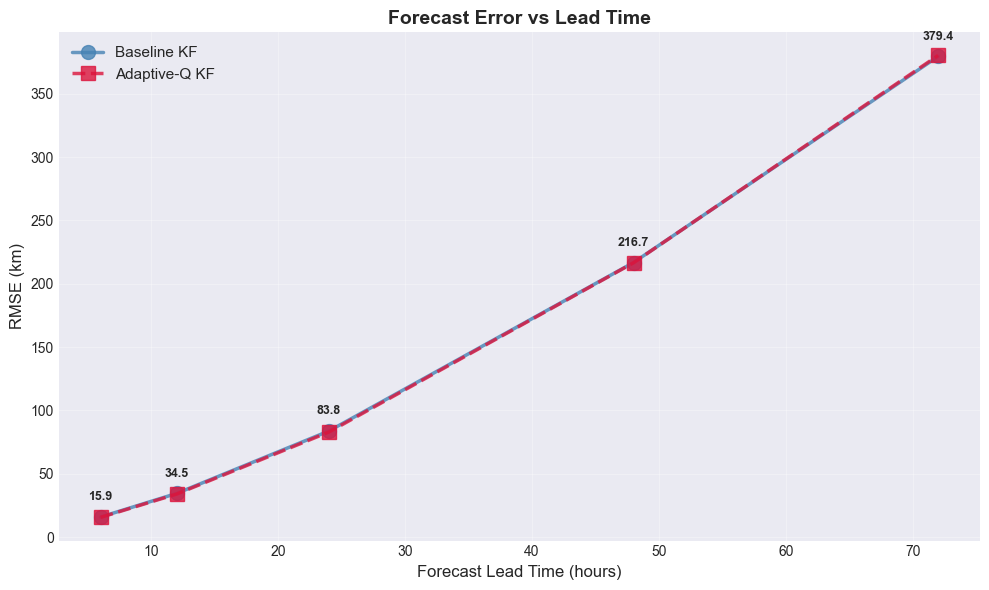

Saved: figures/fig8b_error_distribution_by_leadtime.png


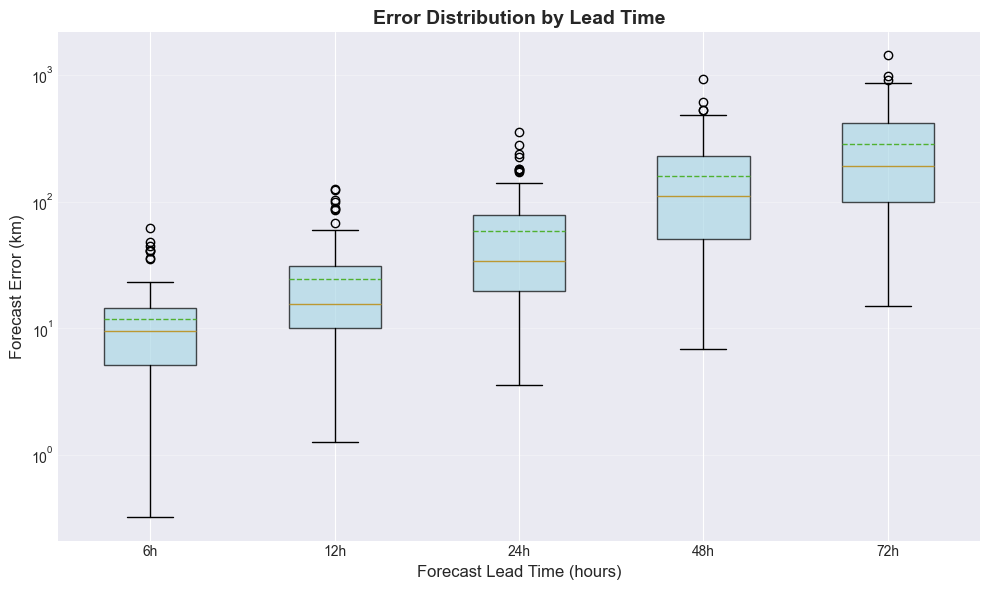

In [ ]:
def plot_forecast_error_vs_leadtime_actual(sliding_results_baseline=None, 
                                           sliding_results_improved=None, 
                                           save_dir=None):
    """
    Plot RMSE vs lead time using actual sliding window forecast results
    Saves each graph separately
    
    Args:
        sliding_results_baseline: DataFrame with columns ['lead_time_hours', 'error_km']
        sliding_results_improved: DataFrame with columns ['lead_time_hours', 'error_km']
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Calculate RMSE by lead time for baseline
    if 'lead_time_hours' not in sliding_results_baseline.columns:
        print("Error: sliding_results_baseline missing 'lead_time_hours' column")
        return
    
    baseline_rmse = sliding_results_baseline.groupby('lead_time_hours')['error_km'].apply(
        lambda x: np.sqrt(np.mean(x**2))
    ).sort_index()
    lead_times = baseline_rmse.index.values
    
    # Plot 1: RMSE comparison (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(lead_times, baseline_rmse.values, 'o-', linewidth=2.5, markersize=10, 
            label='Baseline KF', color='steelblue', alpha=0.8)
    
    # Plot improved model if available
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        if 'lead_time_hours' in sliding_results_improved.columns:
            improved_rmse = sliding_results_improved.groupby('lead_time_hours')['error_km'].apply(
                lambda x: np.sqrt(np.mean(x**2))
            ).sort_index()
            improved_lead_times = improved_rmse.index.values
            ax1.plot(improved_lead_times, improved_rmse.values, 's-', linewidth=2.5, 
                    markersize=10, label='Adaptive-Q KF', color='crimson', 
                    linestyle='--', alpha=0.8)
    
    ax1.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax1.set_ylabel('RMSE (km)', fontsize=12)
    ax1.set_title('Forecast Error vs Lead Time', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for lt, rmse in zip(lead_times, baseline_rmse.values):
        ax1.annotate(f'{rmse:.1f}', (lt, rmse), textcoords="offset points", 
                   xytext=(0,12), ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    save_path1 = f'{save_dir}fig8a_forecast_error_rmse.png'
    plt.savefig(save_path1, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path1}")
    plt.show()
    
    # Plot 2: Error distribution by lead time (box plot style) - separate figure
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    error_data = []
    labels = []
    for lt in sorted(sliding_results_baseline['lead_time_hours'].unique()):
        errors = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km'].values
        error_data.append(errors)
        labels.append(f'{int(lt)}h')
    
    bp = ax2.boxplot(error_data, labels=labels, patch_artist=True, 
                    showmeans=True, meanline=True)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax2.set_ylabel('Forecast Error (km)', fontsize=12)
    ax2.set_title('Error Distribution by Lead Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    save_path2 = f'{save_dir}fig8b_error_distribution_by_leadtime.png'
    plt.savefig(save_path2, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path2}")
    plt.show()

# Plot using actual results
if sliding_results is not None and len(sliding_results) > 0:
    plot_forecast_error_vs_leadtime_actual(
        sliding_results_baseline=sliding_results,
        sliding_results_improved=sliding_results_final,
        save_dir=SAVE_DIR
    )
else:
    print("Run the evaluation cells first to generate sliding_results!")


### Figure 9 — Error Distribution Analysis (Test Set Performance)


Saved: figures/fig9a_rmse_distribution.png


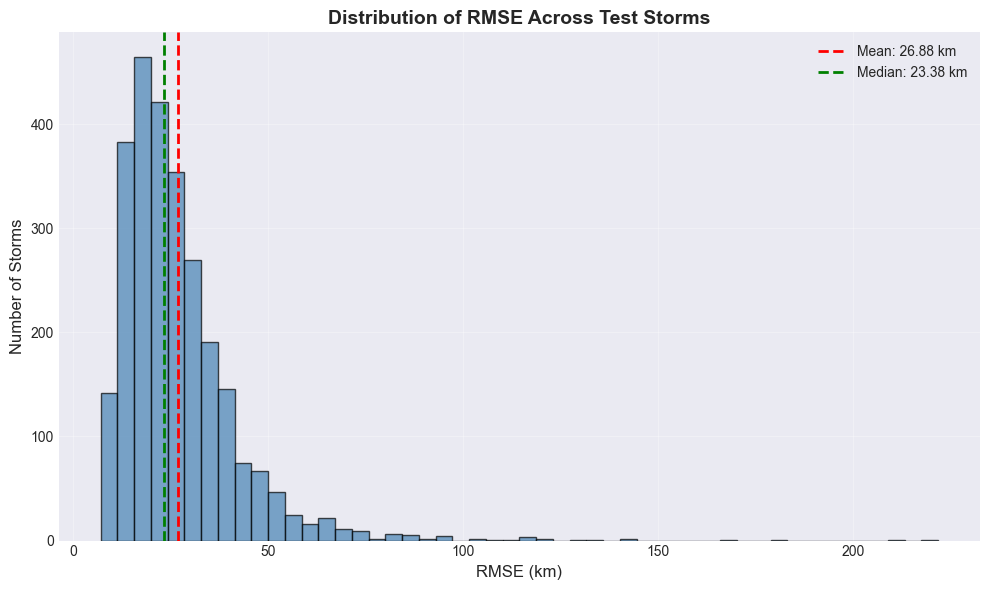

Saved: figures/fig9b_mean_error_distribution.png


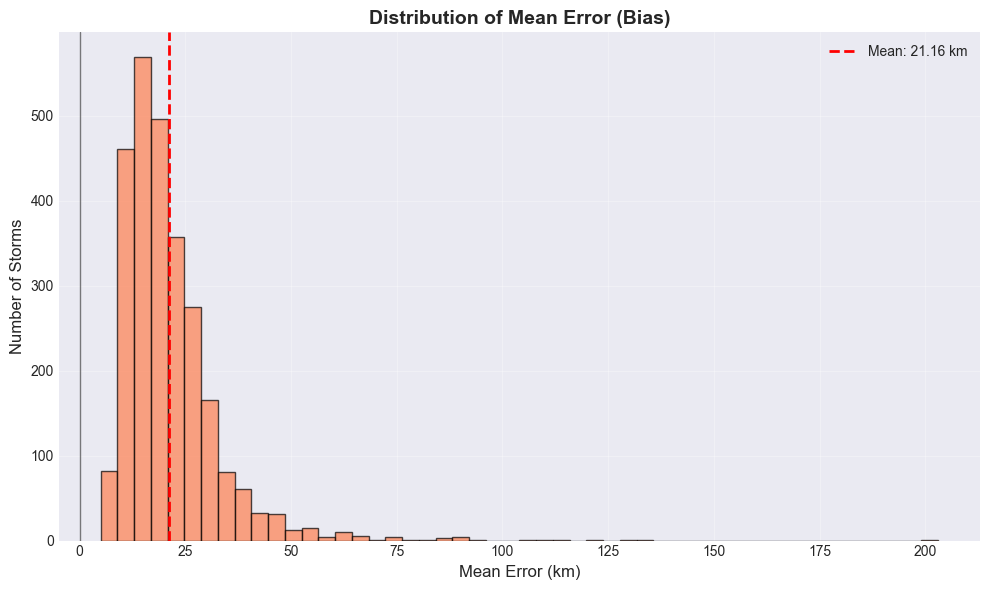

Saved: figures/fig9c_rmse_vs_storm_length.png


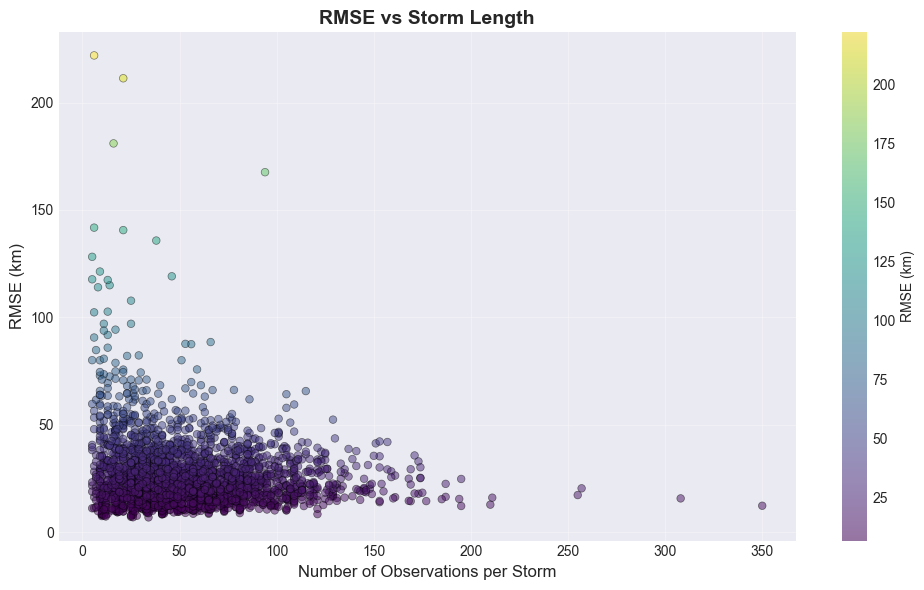

Saved: figures/fig9d_cumulative_rmse_distribution.png


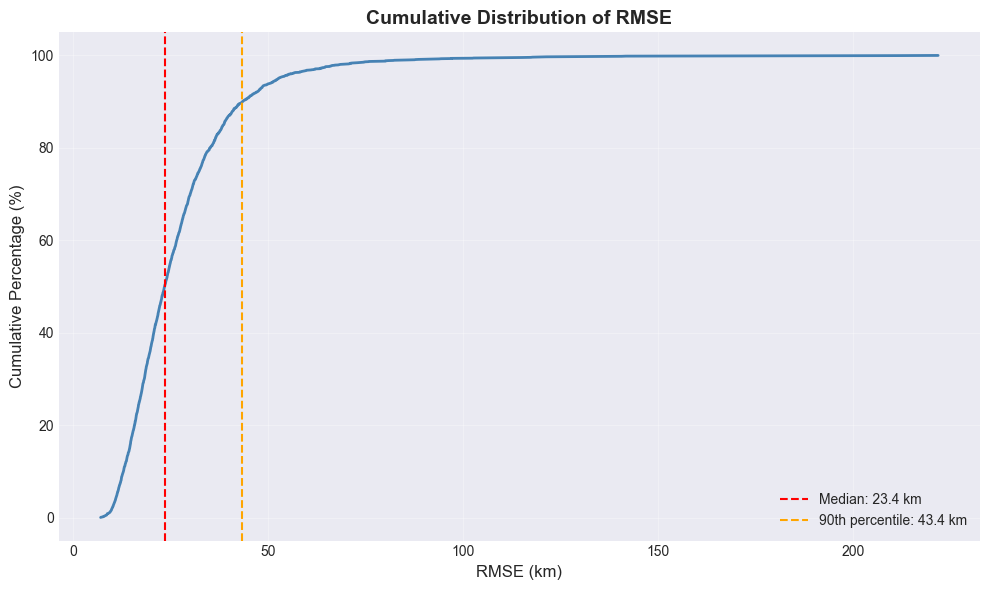

Saved: figures/fig9e_error_by_storm_length.png


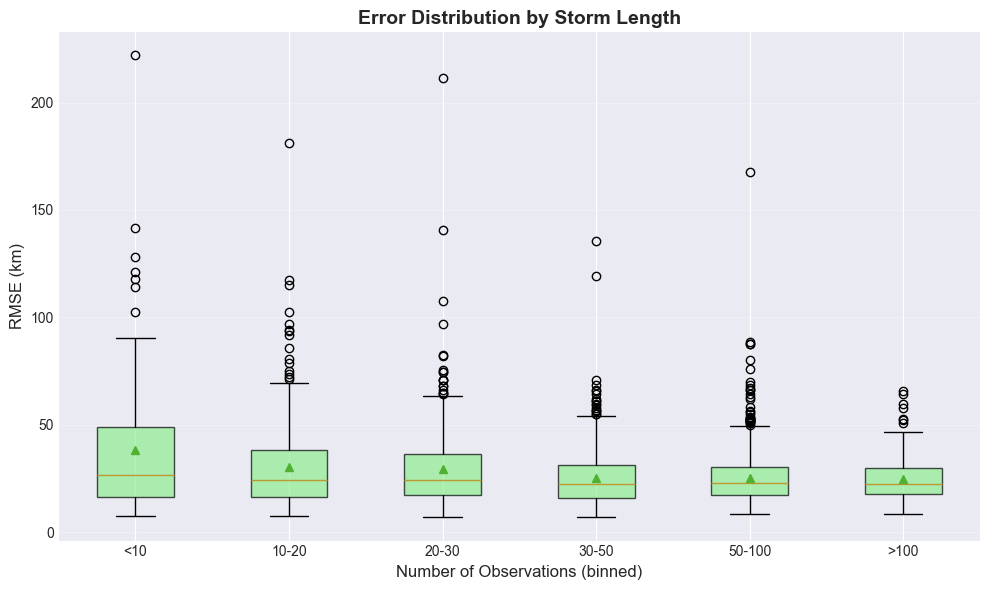

In [ ]:
def plot_error_distribution_analysis(test_results=None, save_dir=None):
    """
    Plot comprehensive error distribution analysis from test set evaluation
    Saves each graph separately
    
    Args:
        test_results: DataFrame with columns ['sid', 'mean_error', 'rmse', 'median_error', 'n_obs']
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Plot 1: Histogram of RMSE across storms (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.hist(test_results['rmse'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(test_results['rmse'].mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {test_results["rmse"].mean():.2f} km')
    ax1.axvline(test_results['rmse'].median(), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {test_results["rmse"].median():.2f} km')
    ax1.set_xlabel('RMSE (km)', fontsize=12)
    ax1.set_ylabel('Number of Storms', fontsize=12)
    ax1.set_title('Distribution of RMSE Across Test Storms', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9a_rmse_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9a_rmse_distribution.png")
    plt.show()
    
    # Plot 2: Histogram of mean error (separate figure)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.hist(test_results['mean_error'], bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(test_results['mean_error'].mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {test_results["mean_error"].mean():.2f} km')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Mean Error (km)', fontsize=12)
    ax2.set_ylabel('Number of Storms', fontsize=12)
    ax2.set_title('Distribution of Mean Error (Bias)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9b_mean_error_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9b_mean_error_distribution.png")
    plt.show()
    
    # Plot 3: RMSE vs Number of Observations (separate figure)
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    scatter = ax3.scatter(test_results['n_obs'], test_results['rmse'], 
                         alpha=0.5, s=30, c=test_results['rmse'], 
                         cmap='viridis', edgecolors='black', linewidths=0.5)
    ax3.set_xlabel('Number of Observations per Storm', fontsize=12)
    ax3.set_ylabel('RMSE (km)', fontsize=12)
    ax3.set_title('RMSE vs Storm Length', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='RMSE (km)')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9c_rmse_vs_storm_length.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9c_rmse_vs_storm_length.png")
    plt.show()
    
    # Plot 4: Cumulative distribution of errors (separate figure)
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    sorted_rmse = np.sort(test_results['rmse'])
    p = np.arange(1, len(sorted_rmse) + 1) / len(sorted_rmse) * 100
    ax4.plot(sorted_rmse, p, linewidth=2, color='steelblue')
    ax4.axvline(test_results['rmse'].quantile(0.5), color='red', linestyle='--', 
               label=f'Median: {test_results["rmse"].quantile(0.5):.1f} km')
    ax4.axvline(test_results['rmse'].quantile(0.9), color='orange', linestyle='--', 
               label=f'90th percentile: {test_results["rmse"].quantile(0.9):.1f} km')
    ax4.set_xlabel('RMSE (km)', fontsize=12)
    ax4.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax4.set_title('Cumulative Distribution of RMSE', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9d_cumulative_rmse_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9d_cumulative_rmse_distribution.png")
    plt.show()
    
    # Plot 5: Box plot of errors by observation count bins (separate figure)
    fig5, ax5 = plt.subplots(figsize=(10, 6))
    test_results_copy = test_results.copy()
    test_results_copy['obs_bin'] = pd.cut(test_results_copy['n_obs'], 
                                     bins=[0, 10, 20, 30, 50, 100, 1000],
                                     labels=['<10', '10-20', '20-30', '30-50', '50-100', '>100'])
    error_by_bin = [test_results_copy[test_results_copy['obs_bin'] == bin_label]['rmse'].values 
                    for bin_label in test_results_copy['obs_bin'].cat.categories]
    bp = ax5.boxplot(error_by_bin, labels=test_results_copy['obs_bin'].cat.categories, 
                    patch_artist=True, showmeans=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    ax5.set_xlabel('Number of Observations (binned)', fontsize=12)
    ax5.set_ylabel('RMSE (km)', fontsize=12)
    ax5.set_title('Error Distribution by Storm Length', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9e_error_by_storm_length.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9e_error_by_storm_length.png")
    plt.show()

# Plot error distribution analysis
if test_results is not None and len(test_results) > 0:
    plot_error_distribution_analysis(test_results, save_dir=SAVE_DIR)
else:
    print("test_results not available. Run test set evaluation first!")


### Figure 10 — Innovation Analysis (Prediction Uncertainty)


Saved: figures/fig10a_innovation_distribution.png


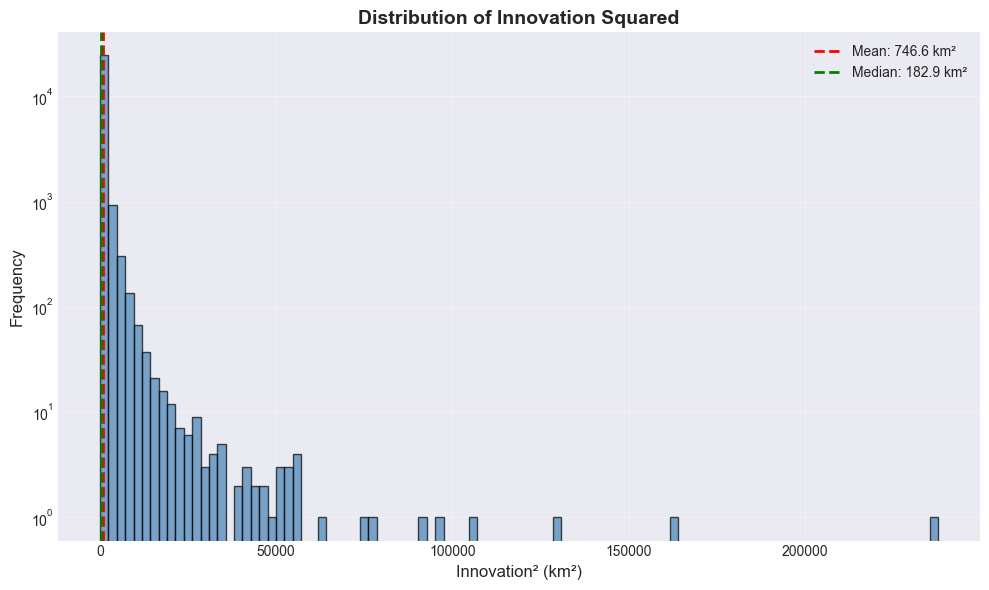

Saved: figures/fig10b_innovation_vs_curvature.png


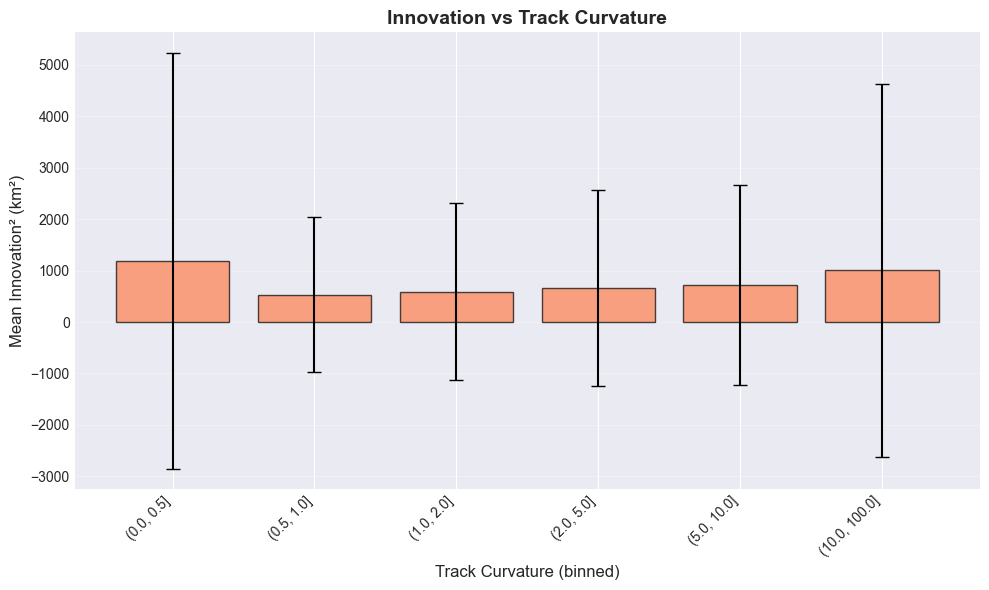

Saved: figures/fig10c_innovation_vs_land.png


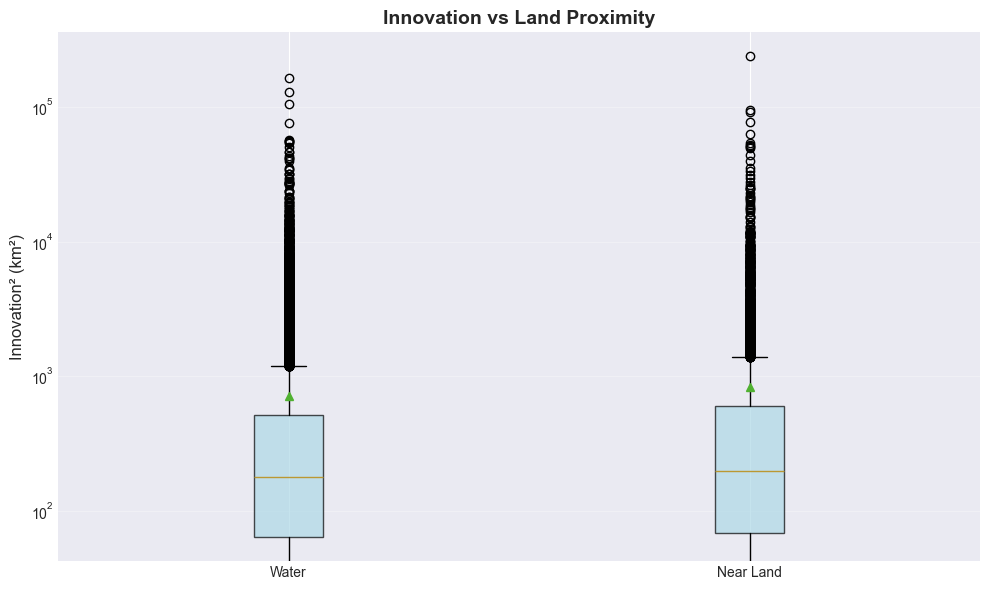

Saved: figures/fig10d_innovation_vs_motion_regime.png


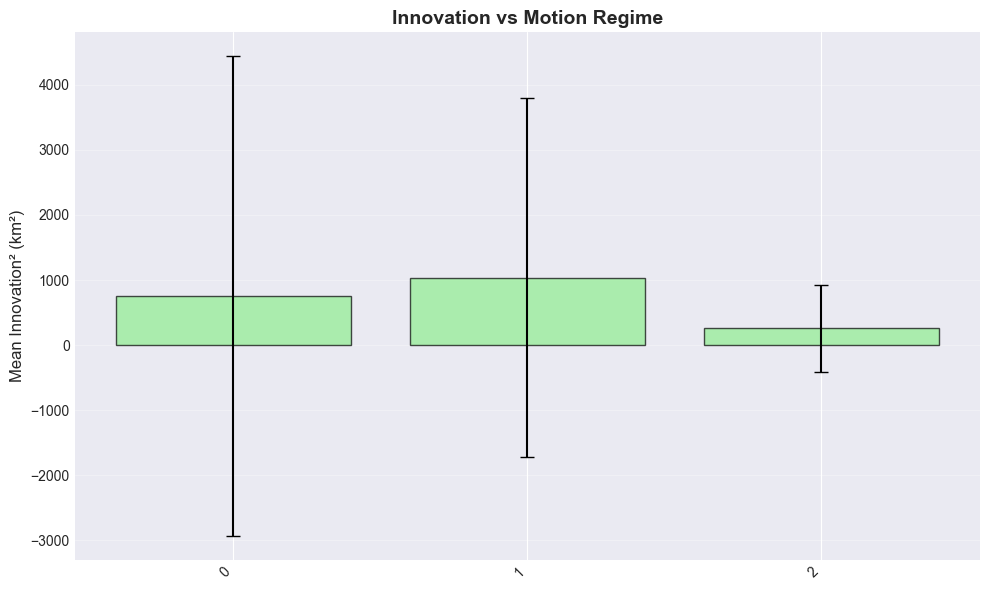

Saved: figures/fig10e_innovation_vs_latitude_regime.png


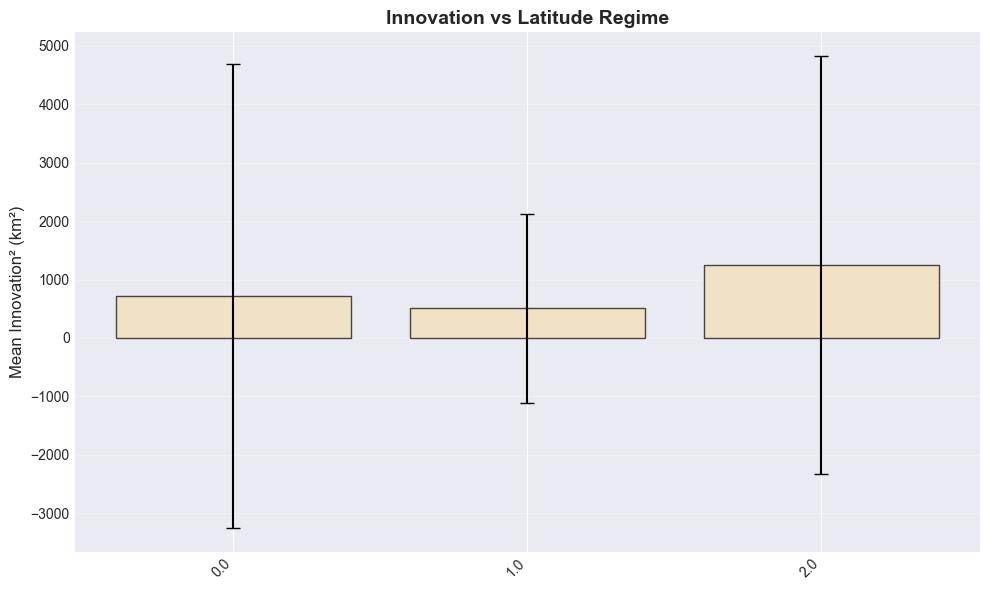

Saved: figures/fig10f_innovation_vs_curvature_scatter.png


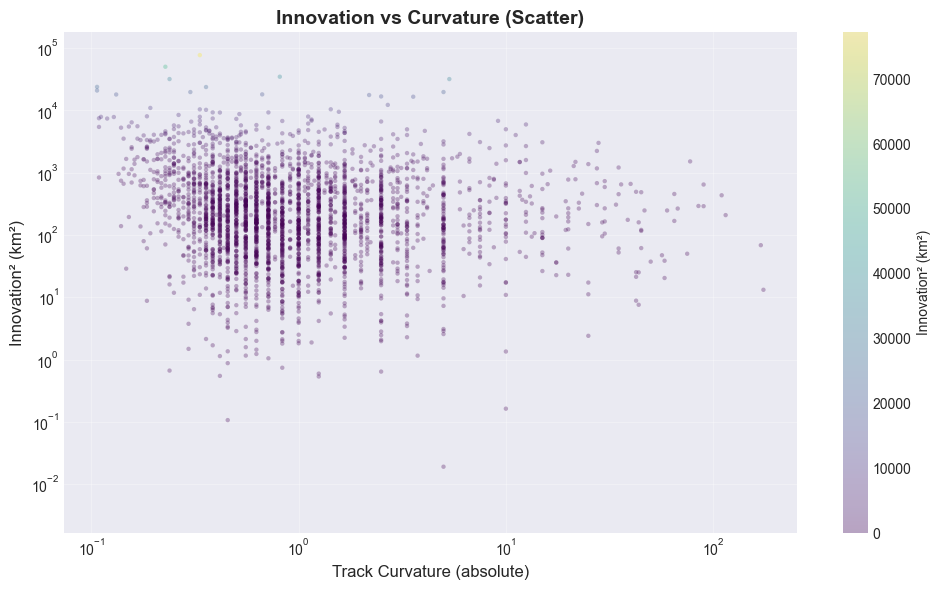

Saved: figures/fig10g_mahalanobis_distance.png


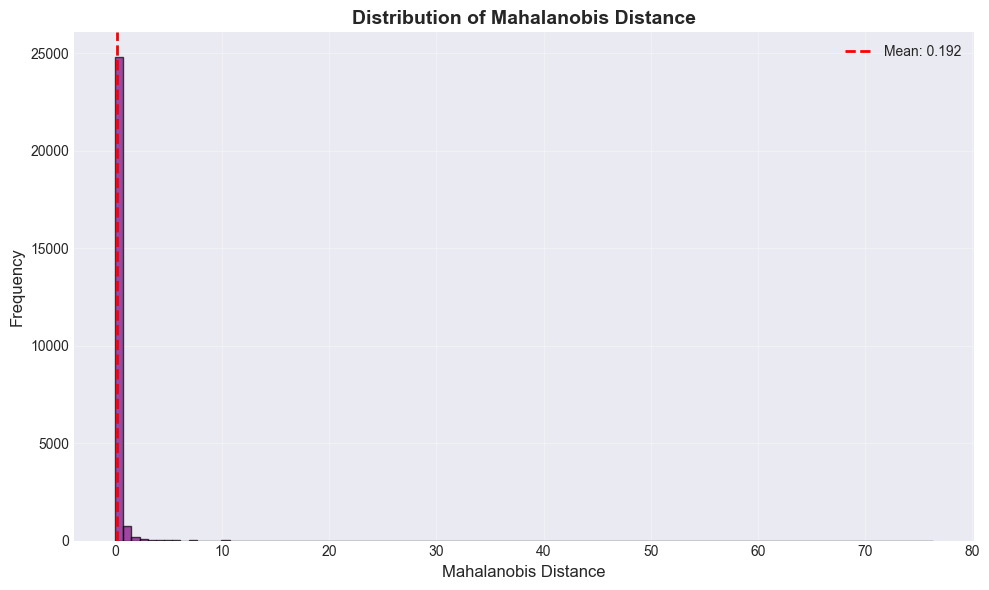

Saved: figures/fig10h_innovation_components.png


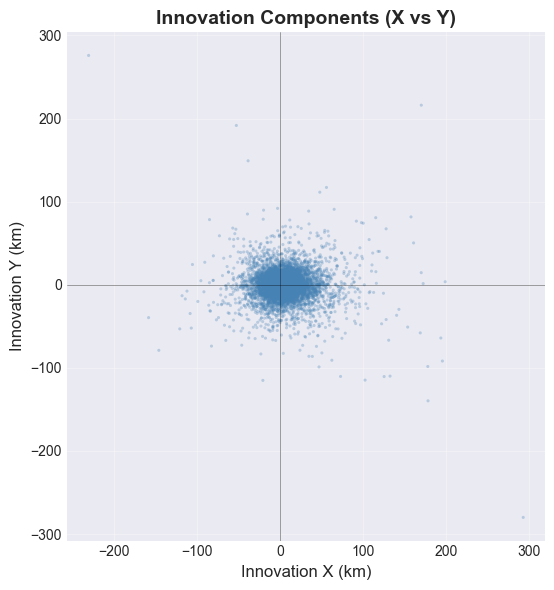

In [ ]:
def plot_innovation_analysis(innovation_df=None, save_dir=None):
    """
    Plot innovation analysis showing how prediction uncertainty relates to storm features
    Saves each graph separately
    
    Args:
        innovation_df: DataFrame with innovation data and feature columns
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Plot 1: Innovation squared distribution (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    innovation_sq = innovation_df['innovation_squared'].dropna()
    ax1.hist(innovation_sq, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Innovation² (km²)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Innovation Squared', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.axvline(innovation_sq.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {innovation_sq.mean():.1f} km²')
    ax1.axvline(innovation_sq.median(), color='green', linestyle='--', linewidth=2,
               label=f'Median: {innovation_sq.median():.1f} km²')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig10a_innovation_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig10a_innovation_distribution.png")
    plt.show()
    
    # Plot 2: Innovation vs Track Curvature (separate figure)
    if 'track_curvature' in innovation_df.columns:
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        curv_data = innovation_df[innovation_df['track_curvature'].notna()].copy()
        curv_data['curvature_abs'] = curv_data['track_curvature'].abs()
        
        # Create bins for curvature
        curv_bins = [0, 0.5, 1, 2, 5, 10, 100]
        curv_data['curvature_bin'] = pd.cut(curv_data['curvature_abs'], bins=curv_bins)
        
        innovation_by_curv = curv_data.groupby('curvature_bin')['innovation_squared'].agg(['mean', 'median', 'std'])
        
        x_pos = np.arange(len(innovation_by_curv))
        ax2.bar(x_pos, innovation_by_curv['mean'], alpha=0.7, color='coral', 
               edgecolor='black', yerr=innovation_by_curv['std'], capsize=5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([str(c) for c in innovation_by_curv.index], rotation=45, ha='right')
        ax2.set_xlabel('Track Curvature (binned)', fontsize=12)
        ax2.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax2.set_title('Innovation vs Track Curvature', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10b_innovation_vs_curvature.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10b_innovation_vs_curvature.png")
        plt.show()
    
    # Plot 3: Innovation vs Land Approach (separate figure)
    if 'is_approaching_land' in innovation_df.columns:
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        land_data = innovation_df[innovation_df['is_approaching_land'].notna()].copy()
        
        land_0 = land_data[land_data['is_approaching_land'] == 0]['innovation_squared']
        land_1 = land_data[land_data['is_approaching_land'] == 1]['innovation_squared']
        
        bp = ax3.boxplot([land_0, land_1], labels=['Water', 'Near Land'], 
                        patch_artist=True, showmeans=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
        ax3.set_ylabel('Innovation² (km²)', fontsize=12)
        ax3.set_title('Innovation vs Land Proximity', fontsize=14, fontweight='bold')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10c_innovation_vs_land.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10c_innovation_vs_land.png")
        plt.show()
    
    # Plot 4: Innovation vs Motion Regime (separate figure)
    if 'motion_regime' in innovation_df.columns:
        fig4, ax4 = plt.subplots(figsize=(10, 6))
        regime_data = innovation_df[innovation_df['motion_regime'].notna()].copy()
        
        innovation_by_regime = regime_data.groupby('motion_regime')['innovation_squared'].agg(['mean', 'std'])
        
        x_pos = np.arange(len(innovation_by_regime))
        ax4.bar(x_pos, innovation_by_regime['mean'], alpha=0.7, color='lightgreen',
               edgecolor='black', yerr=innovation_by_regime['std'], capsize=5)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(innovation_by_regime.index, rotation=45, ha='right')
        ax4.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax4.set_title('Innovation vs Motion Regime', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10d_innovation_vs_motion_regime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10d_innovation_vs_motion_regime.png")
        plt.show()
    
    # Plot 5: Innovation vs Latitude Regime (separate figure)
    if 'latitude_regime' in innovation_df.columns:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        lat_data = innovation_df[innovation_df['latitude_regime'].notna()].copy()
        
        innovation_by_lat = lat_data.groupby('latitude_regime')['innovation_squared'].agg(['mean', 'std'])
        
        x_pos = np.arange(len(innovation_by_lat))
        ax5.bar(x_pos, innovation_by_lat['mean'], alpha=0.7, color='wheat',
               edgecolor='black', yerr=innovation_by_lat['std'], capsize=5)
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(innovation_by_lat.index, rotation=45, ha='right')
        ax5.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax5.set_title('Innovation vs Latitude Regime', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10e_innovation_vs_latitude_regime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10e_innovation_vs_latitude_regime.png")
        plt.show()
    
    # Plot 6: Scatter plot of innovation vs curvature (separate figure)
    if 'track_curvature' in innovation_df.columns:
        fig6, ax6 = plt.subplots(figsize=(10, 6))
        curv_scatter = innovation_df[innovation_df['track_curvature'].notna()].copy()
        curv_scatter['curvature_abs'] = curv_scatter['track_curvature'].abs()
        
        # Sample for visualization if too many points
        if len(curv_scatter) > 5000:
            curv_scatter = curv_scatter.sample(n=5000, random_state=42)
        
        scatter = ax6.scatter(curv_scatter['curvature_abs'], curv_scatter['innovation_squared'],
                             alpha=0.3, s=10, c=curv_scatter['innovation_squared'],
                             cmap='viridis', edgecolors='none')
        ax6.set_xlabel('Track Curvature (absolute)', fontsize=12)
        ax6.set_ylabel('Innovation² (km²)', fontsize=12)
        ax6.set_title('Innovation vs Curvature (Scatter)', fontsize=14, fontweight='bold')
        ax6.set_yscale('log')
        ax6.set_xscale('log')
        ax6.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax6, label='Innovation² (km²)')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10f_innovation_vs_curvature_scatter.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10f_innovation_vs_curvature_scatter.png")
        plt.show()
    
    # Plot 7: Mahalanobis distance distribution (separate figure)
    if 'mahalanobis_distance' in innovation_df.columns:
        fig7, ax7 = plt.subplots(figsize=(10, 6))
        mahal_dist = innovation_df['mahalanobis_distance'].dropna()
        ax7.hist(mahal_dist, bins=100, edgecolor='black', alpha=0.7, color='purple')
        ax7.set_xlabel('Mahalanobis Distance', fontsize=12)
        ax7.set_ylabel('Frequency', fontsize=12)
        ax7.set_title('Distribution of Mahalanobis Distance', fontsize=14, fontweight='bold')
        ax7.axvline(mahal_dist.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mahal_dist.mean():.3f}')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10g_mahalanobis_distance.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10g_mahalanobis_distance.png")
        plt.show()
    
    # Plot 8: Innovation components (x vs y) (separate figure)
    if 'innovation_x' in innovation_df.columns and 'innovation_y' in innovation_df.columns:
        fig8, ax8 = plt.subplots(figsize=(10, 6))
        innov_sample = innovation_df[['innovation_x', 'innovation_y']].dropna()
        if len(innov_sample) > 10000:
            innov_sample = innov_sample.sample(n=10000, random_state=42)
        
        ax8.scatter(innov_sample['innovation_x'], innov_sample['innovation_y'],
                   alpha=0.3, s=5, c='steelblue', edgecolors='none')
        ax8.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax8.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax8.set_xlabel('Innovation X (km)', fontsize=12)
        ax8.set_ylabel('Innovation Y (km)', fontsize=12)
        ax8.set_title('Innovation Components (X vs Y)', fontsize=14, fontweight='bold')
        ax8.grid(True, alpha=0.3)
        ax8.set_aspect('equal')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10h_innovation_components.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10h_innovation_components.png")
        plt.show()

# Plot innovation analysis
if innovation_df is not None and len(innovation_df) > 0:
    plot_innovation_analysis(innovation_df, save_dir=SAVE_DIR)
else:
    print("innovation_df not available. Run feature validation first!")


### Figure 11 — Model Comparison (Baseline vs Adaptive-Q)


Saved: figures/fig11a_rmse_comparison.png


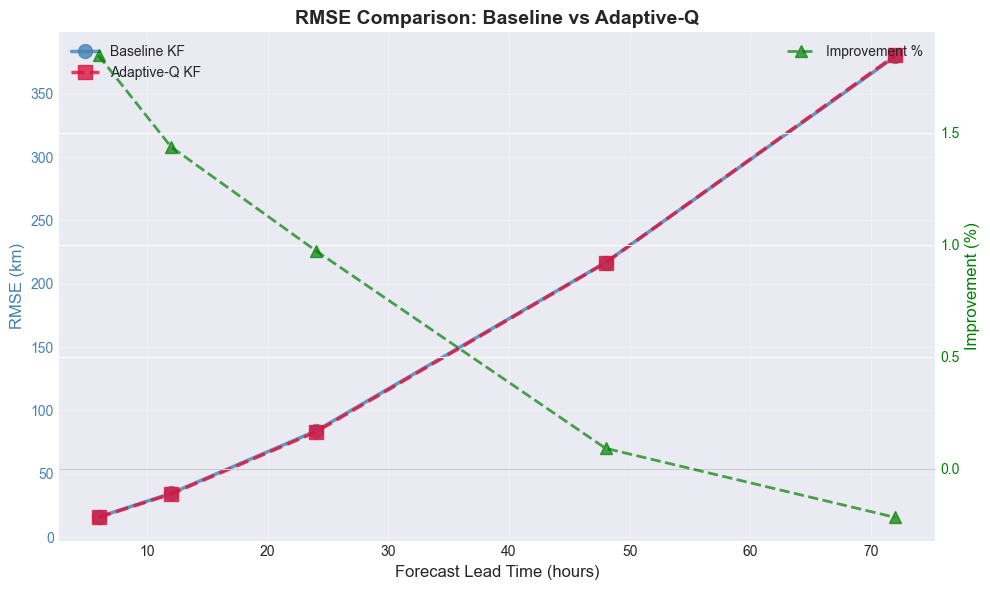

Saved: figures/fig11b_error_distribution_comparison.png


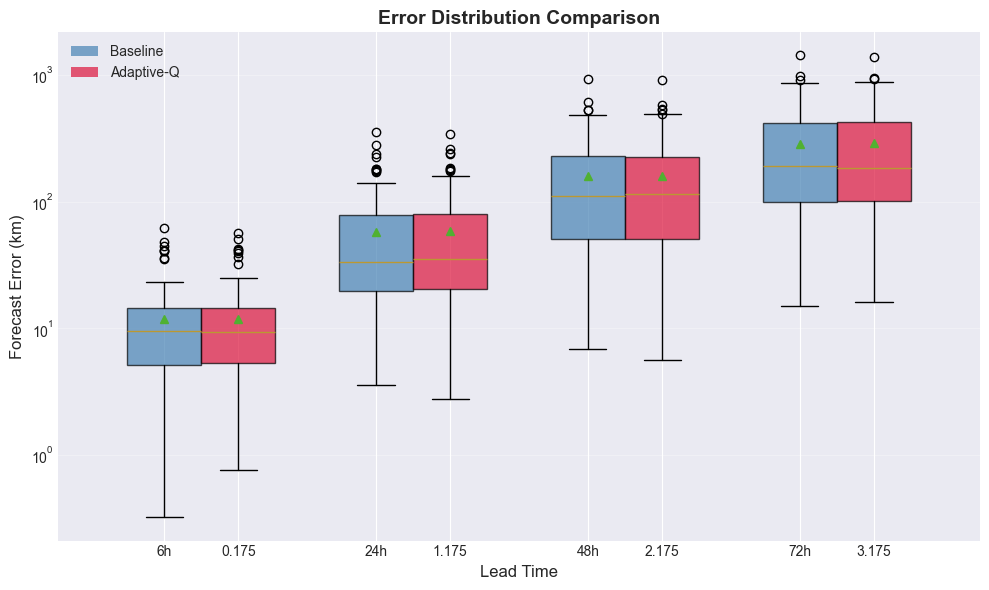

Saved: figures/fig11c_improvement_by_leadtime.png


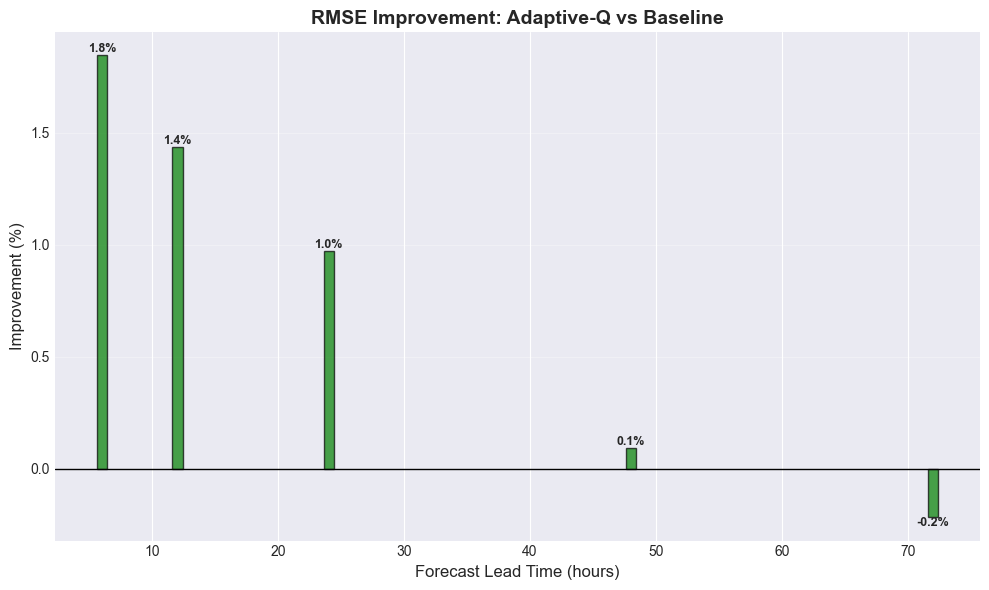

Saved: figures/fig11d_cumulative_error_comparison.png


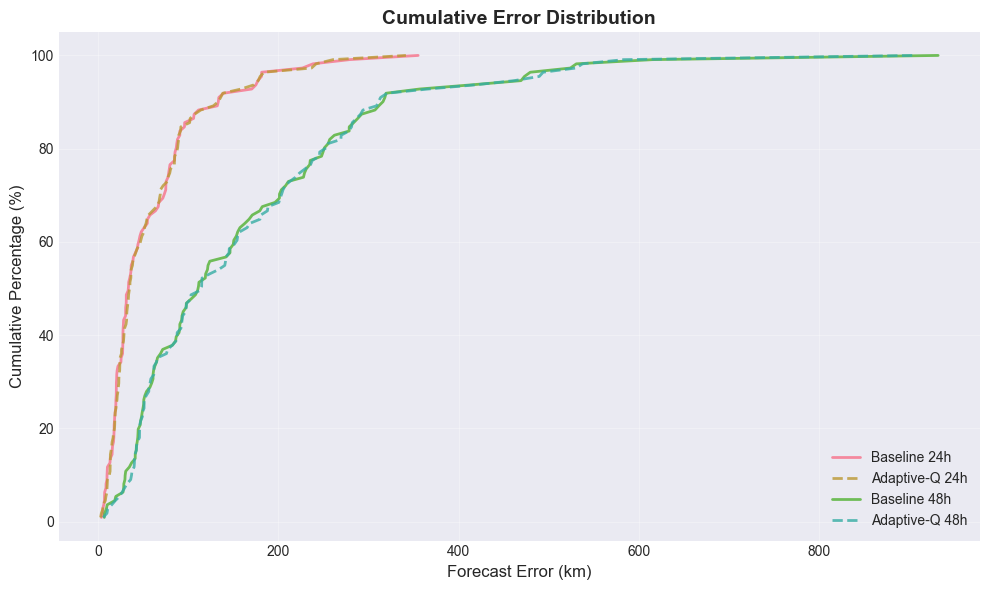

Saved: figures/fig11e_error_scatter_comparison.png


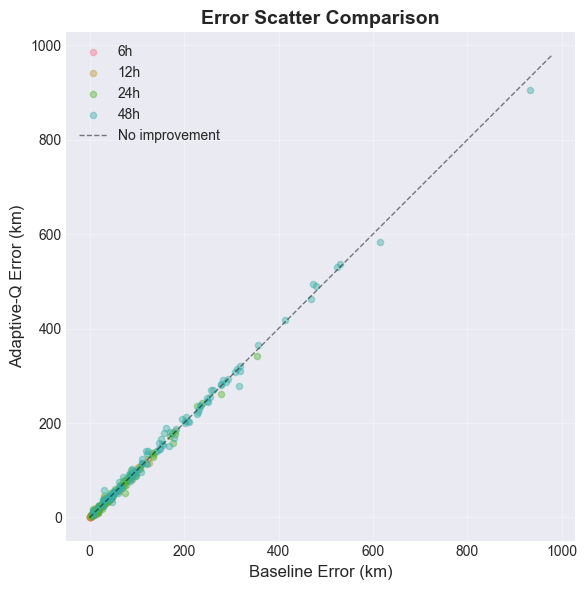

In [ ]:
def plot_model_comparison(sliding_results_baseline=None, sliding_results_improved=None,
                          save_dir=None):
    """
    Comprehensive comparison between baseline and adaptive-Q models
    Saves each graph separately
    
    Args:
        sliding_results_baseline: DataFrame with baseline forecast results
        sliding_results_improved: DataFrame with adaptive-Q forecast results
        save_dir: Directory to save figures
    """
    

    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Calculate statistics for baseline
    baseline_stats = sliding_results_baseline.groupby('lead_time_hours')['error_km'].agg([
        lambda x: np.sqrt(np.mean(x**2)),  # RMSE
        'mean',  # Mean error
        'median',  # Median error
        lambda x: np.percentile(x, 25),  # Q25
        lambda x: np.percentile(x, 75),  # Q75
    ]).sort_index()
    baseline_stats.columns = ['rmse', 'mean', 'median', 'q25', 'q75']
    
    lead_times = baseline_stats.index.values
    
    # Calculate improved stats if available
    improved_stats = None
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        improved_stats = sliding_results_improved.groupby('lead_time_hours')['error_km'].agg([
            lambda x: np.sqrt(np.mean(x**2)),
            'mean',
            'median',
            lambda x: np.percentile(x, 25),
            lambda x: np.percentile(x, 75),
        ]).sort_index()
        improved_stats.columns = ['rmse', 'mean', 'median', 'q25', 'q75']
    
    # Plot 1: RMSE comparison (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(lead_times, baseline_stats['rmse'], 'o-', linewidth=2.5, markersize=10,
            label='Baseline KF', color='steelblue', alpha=0.8)
    
    if improved_stats is not None:
        ax1.plot(lead_times, improved_stats['rmse'], 's-', linewidth=2.5, markersize=10,
                label='Adaptive-Q KF', color='crimson', linestyle='--', alpha=0.8)
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_stats['rmse'] - improved_stats['rmse']) / baseline_stats['rmse'] * 100)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(lead_times, improvement_pct, 'g--', linewidth=2, marker='^', markersize=8,
                     label='Improvement %', alpha=0.7)
        ax1_twin.set_ylabel('Improvement (%)', fontsize=12, color='green')
        ax1_twin.tick_params(axis='y', labelcolor='green')
        ax1_twin.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax1_twin.legend(loc='upper right')
    
    ax1.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax1.set_ylabel('RMSE (km)', fontsize=12, color='steelblue')
    ax1.set_title('RMSE Comparison: Baseline vs Adaptive-Q', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11a_rmse_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11a_rmse_comparison.png")
    plt.show()
    
    # Plot 2: Error distribution comparison at key lead times (separate figure)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    key_lead_times = [6, 24, 48, 72]
    key_lead_times = [lt for lt in key_lead_times if lt in lead_times]
    
    baseline_errors = []
    improved_errors = []
    labels = []
    
    for lt in key_lead_times:
        baseline_errors.append(sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km'].values)
        labels.append(f'{int(lt)}h')
        if sliding_results_improved is not None:
            improved_errors.append(sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km'].values)
    
    # Create grouped box plot
    positions = np.arange(len(key_lead_times))
    width = 0.35
    
    bp1 = ax2.boxplot(baseline_errors, positions=positions - width/2, widths=width,
                     patch_artist=True, labels=labels, showmeans=True)
    for patch in bp1['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
    
    if sliding_results_improved is not None and len(improved_errors) > 0:
        bp2 = ax2.boxplot(improved_errors, positions=positions + width/2, widths=width,
                         patch_artist=True, showmeans=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('crimson')
            patch.set_alpha(0.7)
    
    ax2.set_xlabel('Lead Time', fontsize=12)
    ax2.set_ylabel('Forecast Error (km)', fontsize=12)
    ax2.set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='steelblue', alpha=0.7, label='Baseline'),
                       Patch(facecolor='crimson', alpha=0.7, label='Adaptive-Q')]
    ax2.legend(handles=legend_elements, loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11b_error_distribution_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11b_error_distribution_comparison.png")
    plt.show()
    
    # Plot 3: Improvement by lead time (bar chart) (separate figure)
    if improved_stats is not None:
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        improvement_km = baseline_stats['rmse'] - improved_stats['rmse']
        improvement_pct = (improvement_km / baseline_stats['rmse'] * 100)
        
        bars = ax3.bar(lead_times, improvement_pct, alpha=0.7, color='green', edgecolor='black')
        ax3.axhline(0, color='black', linestyle='-', linewidth=1)
        ax3.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
        ax3.set_ylabel('Improvement (%)', fontsize=12)
        ax3.set_title('RMSE Improvement: Adaptive-Q vs Baseline', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, pct in zip(bars, improvement_pct):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{pct:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig11c_improvement_by_leadtime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig11c_improvement_by_leadtime.png")
        plt.show()
    
    # Plot 4: Cumulative error distribution comparison (separate figure)
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    for lt in [24, 48] if 24 in lead_times and 48 in lead_times else [lead_times[0] if len(lead_times) > 0 else 6]:
        if lt not in lead_times:
            continue
        baseline_lt = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km']
        sorted_baseline = np.sort(baseline_lt)
        p_baseline = np.arange(1, len(sorted_baseline) + 1) / len(sorted_baseline) * 100
        
        ax4.plot(sorted_baseline, p_baseline, linewidth=2, label=f'Baseline {int(lt)}h', alpha=0.8)
        
        if sliding_results_improved is not None:
            improved_lt = sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km']
            sorted_improved = np.sort(improved_lt)
            p_improved = np.arange(1, len(sorted_improved) + 1) / len(sorted_improved) * 100
            ax4.plot(sorted_improved, p_improved, linewidth=2, linestyle='--',
                    label=f'Adaptive-Q {int(lt)}h', alpha=0.8)
    
    ax4.set_xlabel('Forecast Error (km)', fontsize=12)
    ax4.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax4.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11d_cumulative_error_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11d_cumulative_error_comparison.png")
    plt.show()
    
    # Plot 5: Error scatter comparison (separate figure)
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        # Compare errors at same lead times
        common_lead_times = set(sliding_results_baseline['lead_time_hours']) & set(sliding_results_improved['lead_time_hours'])
        
        for lt in sorted(common_lead_times)[:4]:  # Show up to 4 lead times
            baseline_errors = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km']
            improved_errors = sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km']
            
            # Sample if too many points
            if len(baseline_errors) > 200:
                idx = np.random.choice(len(baseline_errors), 200, replace=False)
                baseline_errors = baseline_errors.iloc[idx]
                improved_errors = improved_errors.iloc[idx]
            
            ax5.scatter(baseline_errors, improved_errors, alpha=0.4, s=20, label=f'{int(lt)}h')
        
        # Add diagonal line (y=x)
        max_err = max(ax5.get_xlim()[1], ax5.get_ylim()[1])
        ax5.plot([0, max_err], [0, max_err], 'k--', linewidth=1, alpha=0.5, label='No improvement')
        
        ax5.set_xlabel('Baseline Error (km)', fontsize=12)
        ax5.set_ylabel('Adaptive-Q Error (km)', fontsize=12)
        ax5.set_title('Error Scatter Comparison', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        ax5.set_aspect('equal')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig11e_error_scatter_comparison.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig11e_error_scatter_comparison.png")
        plt.show()

# Plot model comparison
if sliding_results is not None and sliding_results_final is not None:
    plot_model_comparison(
        sliding_results_baseline=sliding_results,
        sliding_results_improved=sliding_results_final,
        save_dir=SAVE_DIR
    )
else:
    print("Results not available for comparison. Run evaluations first!")


### Figure 12 — Error Distribution Analysis by Lead Time (Histograms with Normal Overlay)


Saved: figures/fig12a_error_distribution_6h.png


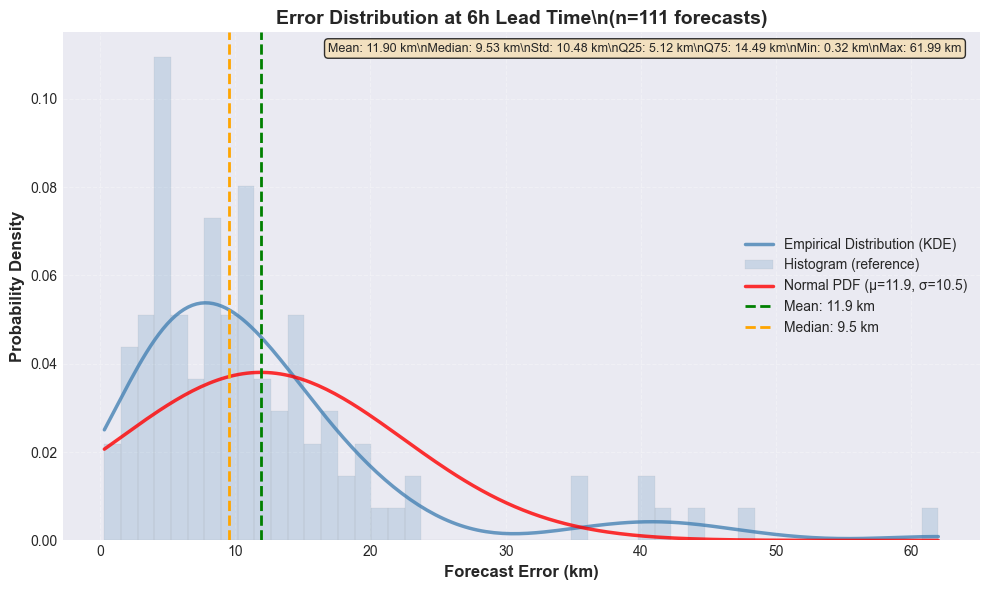

Saved: figures/fig12a_error_distribution_12h.png


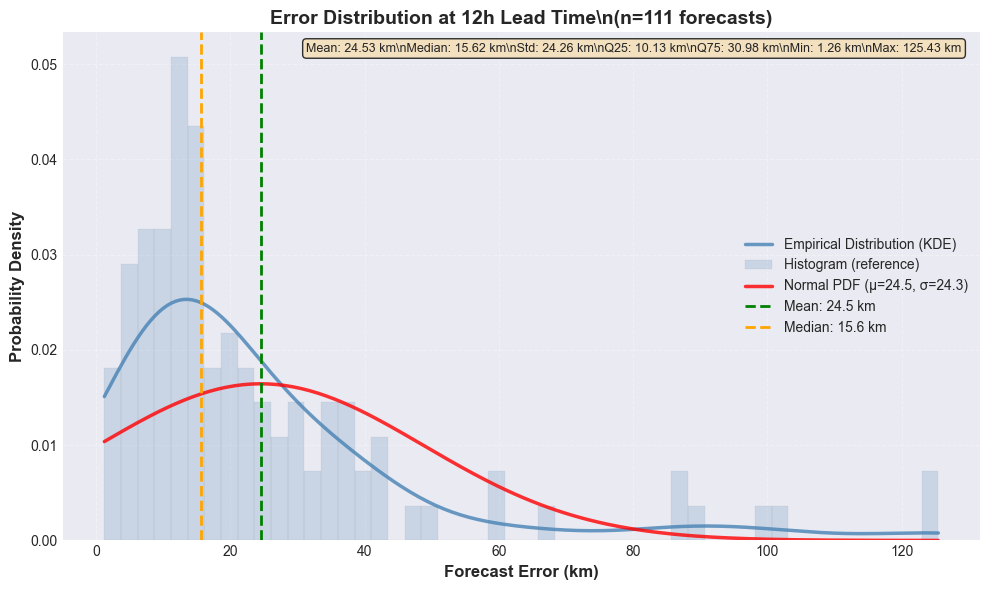

Saved: figures/fig12a_error_distribution_24h.png


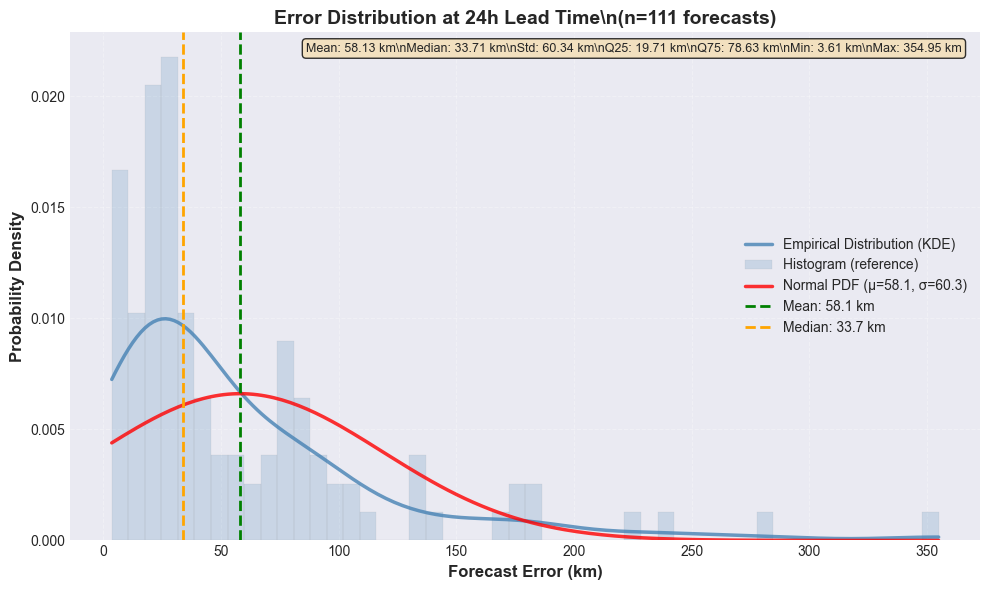

Saved: figures/fig12a_error_distribution_48h.png


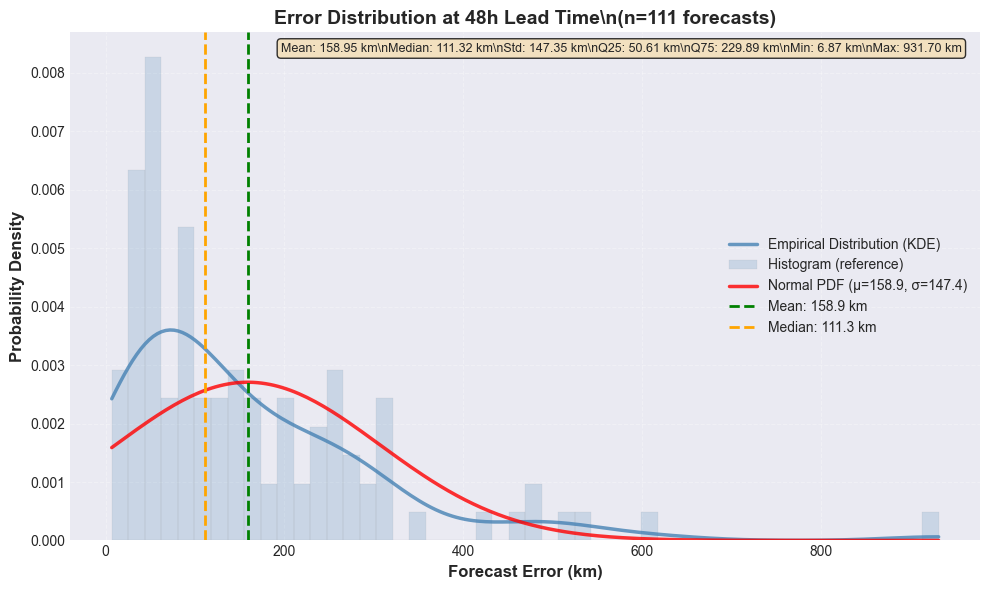

Saved: figures/fig12a_error_distribution_72h.png


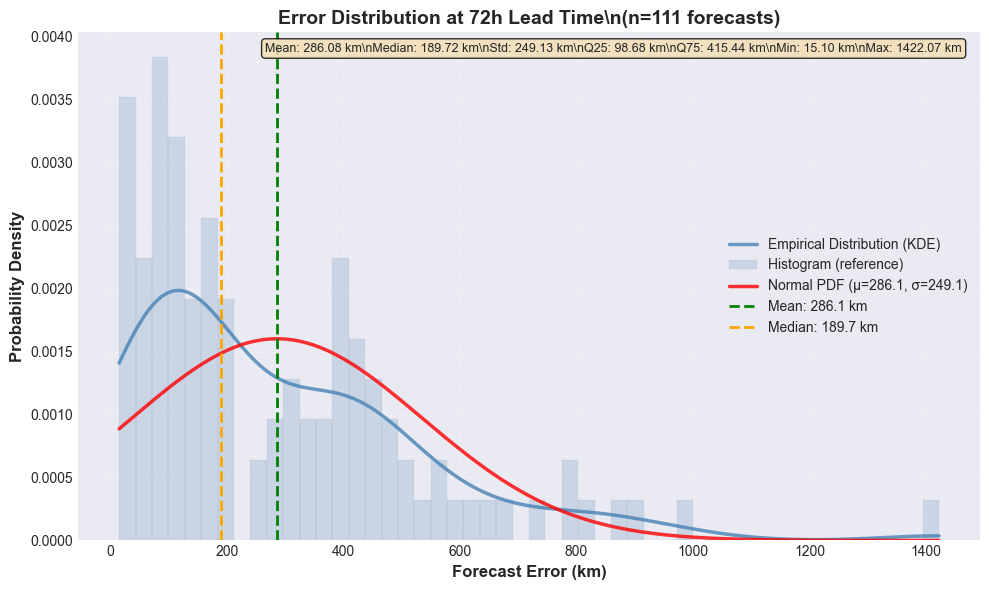

Saved: figures/fig12_average_predictions_over_time_6h.png


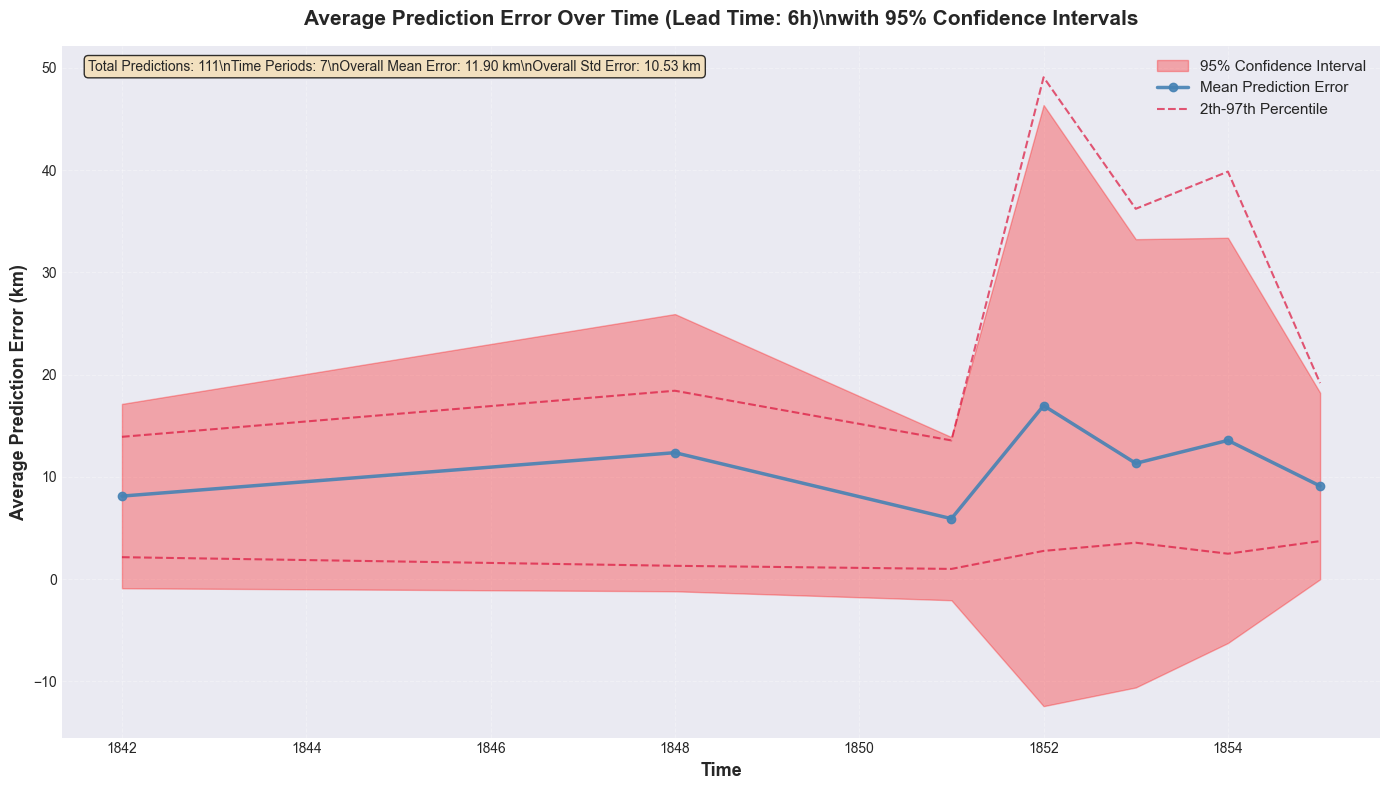

Saved: figures/fig12_average_predictions_over_time_24h.png


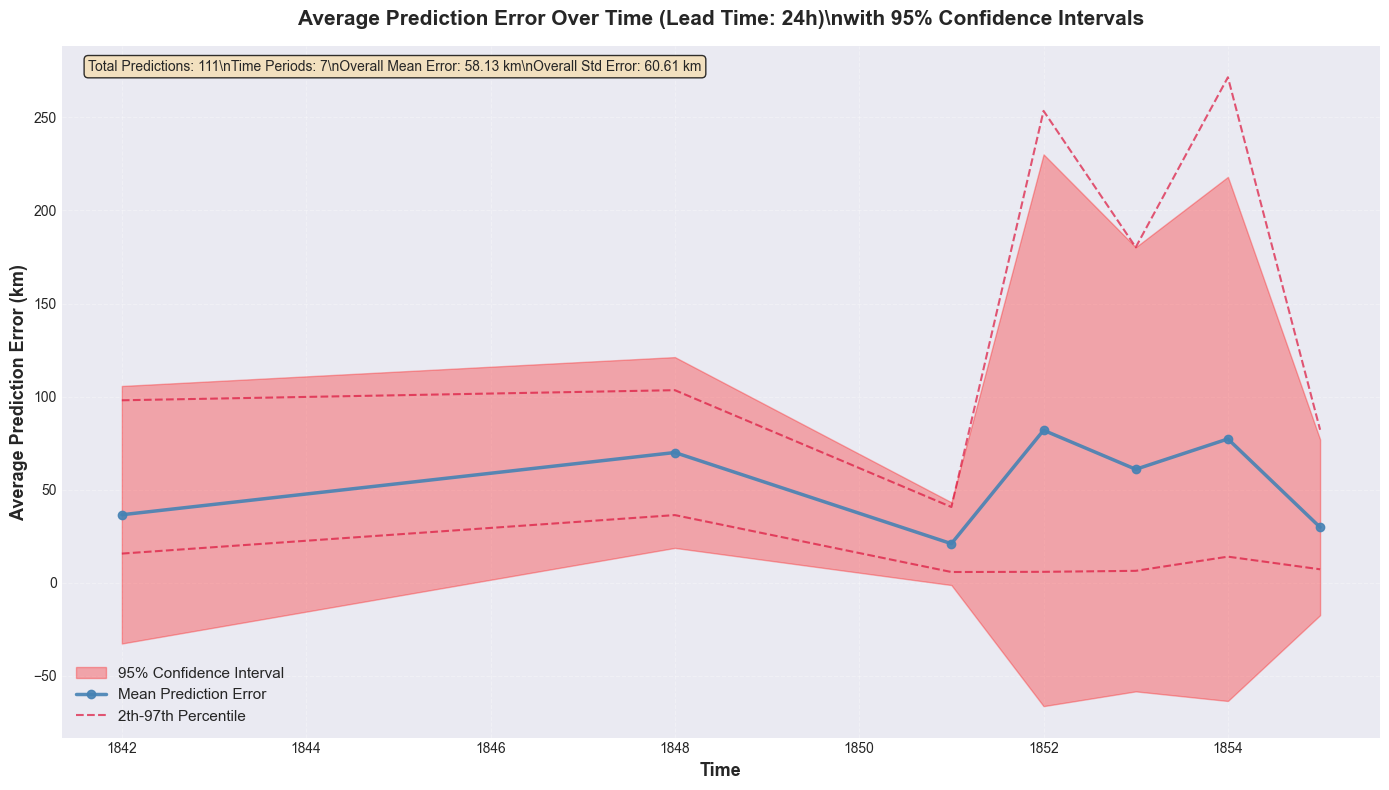

Saved: figures/fig12_average_predictions_over_time_48h.png


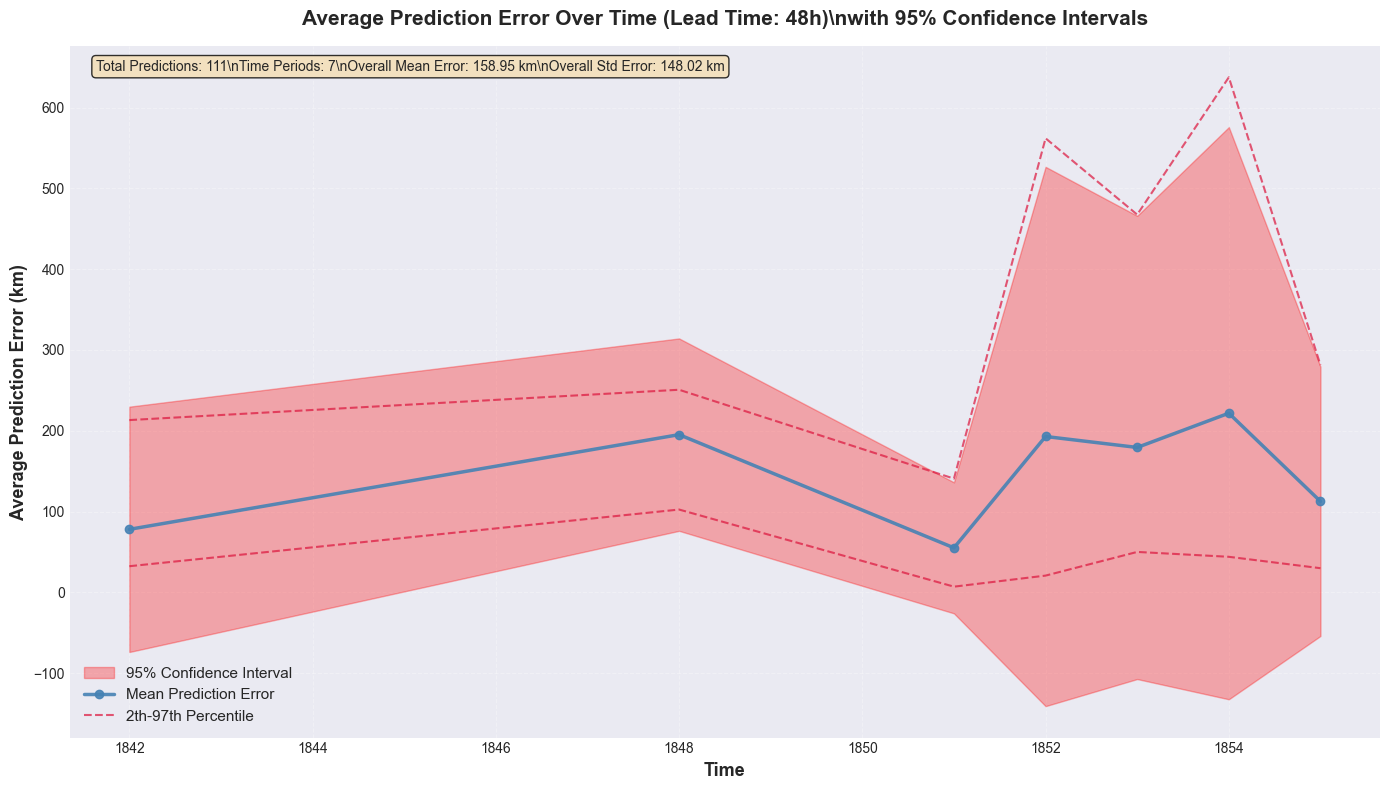

In [30]:
def plot_error_distributions_by_leadtime(sliding_results=None, lead_times=[6, 12, 24, 48, 72],
                                         save_dir=None):
    """
    Plot error distributions (histograms) for each lead time with normal PDF overlay
    
    Args:
        sliding_results: DataFrame with forecast results (lead_time_hours, error_km)
        lead_times: List of lead times to plot
        save_dir: Directory to save figures
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    from scipy import stats
    
    # Filter to available lead times
    available_lead_times = [lt for lt in lead_times if lt in sliding_results['lead_time_hours'].values]
    
    if len(available_lead_times) == 0:
        print("Warning: No data for specified lead times")
        return
    
    # Create separate figure for each lead time
    for lead_time in available_lead_times:
        errors = sliding_results[sliding_results['lead_time_hours'] == lead_time]['error_km'].values
        
        if len(errors) == 0:
            continue
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Calculate normal distribution parameters
        mean_err = np.mean(errors)
        std_err = np.std(errors)
        
        # Create KDE for empirical distribution
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(errors)
        x_range = np.linspace(errors.min(), errors.max(), 200)
        kde_values = kde(x_range)
        
        # Plot KDE (empirical distribution)
        ax.plot(x_range, kde_values, 'b-', linewidth=2.5, 
               color='steelblue', label='Empirical Distribution (KDE)', alpha=0.8)
        
        # Also plot histogram in background for reference (lighter)
        n, bins, patches = ax.hist(errors, bins=50, density=True, alpha=0.2, 
                                  color='steelblue', edgecolor='gray', linewidth=0.3,
                                  label='Histogram (reference)')
        
        # Overlay normal PDF
        normal_pdf = stats.norm.pdf(x_range, loc=mean_err, scale=std_err)
        ax.plot(x_range, normal_pdf, 'r-', linewidth=2.5, 
               label=f'Normal PDF (μ={mean_err:.1f}, σ={std_err:.1f})', alpha=0.8)
        
        # Add statistics
        median_err = np.median(errors)
        q25 = np.percentile(errors, 25)
        q75 = np.percentile(errors, 75)
        
        ax.axvline(mean_err, color='green', linestyle='--', linewidth=2, 
                  label=f'Mean: {mean_err:.1f} km')
        ax.axvline(median_err, color='orange', linestyle='--', linewidth=2, 
                  label=f'Median: {median_err:.1f} km')
        
        ax.set_xlabel('Forecast Error (km)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
        ax.set_title(f'Error Distribution at {lead_time}h Lead Time\\n'
                    f'(n={len(errors):,} forecasts)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # Add statistics text
        stats_text = f"Mean: {mean_err:.2f} km\\n"
        stats_text += f"Median: {median_err:.2f} km\\n"
        stats_text += f"Std: {std_err:.2f} km\\n"
        stats_text += f"Q25: {q25:.2f} km\\n"
        stats_text += f"Q75: {q75:.2f} km\\n"
        stats_text += f"Min: {errors.min():.2f} km\\n"
        stats_text += f"Max: {errors.max():.2f} km"
        
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        save_path = f'{save_dir}fig12a_error_distribution_{lead_time}h.png'
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()

# Plot error distributions
if sliding_results is not None and len(sliding_results) > 0:
    plot_error_distributions_by_leadtime(
        sliding_results=sliding_results,
        lead_times=[6, 12, 24, 48, 72],
        save_dir=SAVE_DIR
    )
else:
    print("sliding_results not available. Run evaluation first!")

def plot_average_predictions_over_time(sliding_results=None, df_main=None, 
                                       time_period='year', lead_time_hours=24,
                                       confidence_level=0.95, save_dir=None):
    """
    Plot average prediction error over time with confidence intervals
    
    Args:
        sliding_results: DataFrame with forecast results (storm_id, lead_time_hours, error_km)
        df_main: Main dataset with iso_time and sid columns
        time_period: 'year', 'month', or 'quarter' for grouping
        lead_time_hours: Which lead time to analyze (default: 24 hours)
        confidence_level: Confidence level for intervals (default: 0.95 = 95%)
    """
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Filter to specific lead time
    results_filtered = sliding_results[sliding_results['lead_time_hours'] == lead_time_hours].copy()
    
    if len(results_filtered) == 0:
        print(f"Warning: No results found for lead_time_hours={lead_time_hours}")
        return
    
    # Extract date from storm_id or merge with main dataset
    # Storm ID format appears to be: YYYYMMDD... 
    # Let's try to extract year from storm_id first
    def extract_year_from_storm_id(storm_id):
        """Extract year from storm ID if possible"""
        try:
            # Try first 4 characters as year
            year_str = str(storm_id)[:4]
            year = int(year_str)
            if 1800 <= year <= 2100:
                return year
        except:
            pass
        return None
    
    # Try extracting year from storm_id
    results_filtered['year'] = results_filtered['storm_id'].apply(extract_year_from_storm_id)
    
    # If that doesn't work well, merge with main dataset to get actual dates
    if results_filtered['year'].isna().sum() > len(results_filtered) * 0.5:
        print("Merging with main dataset to get time information...")
        # Get first observation time for each storm
        storm_times = df_main.groupby('sid')['iso_time'].first().reset_index()
        storm_times.columns = ['storm_id', 'iso_time']
        
        # Merge
        results_filtered = results_filtered.merge(storm_times, on='storm_id', how='left')
        
        if 'iso_time' in results_filtered.columns:
            results_filtered['year'] = results_filtered['iso_time'].dt.year
            results_filtered['month'] = results_filtered['iso_time'].dt.month
            results_filtered['quarter'] = results_filtered['iso_time'].dt.quarter
            results_filtered['date'] = results_filtered['iso_time']
    
    # Remove rows without time information
    results_filtered = results_filtered.dropna(subset=['year'])
    
    if len(results_filtered) == 0:
        print("Error: Could not extract time information from results")
        return
    
    # Group by time period
    if time_period == 'year':
        time_col = 'year'
        results_filtered['time_period'] = results_filtered['year']
    elif time_period == 'month':
        if 'date' in results_filtered.columns:
            results_filtered['time_period'] = results_filtered['date'].dt.to_period('M')
        else:
            print("Warning: Month grouping requires date information. Using year instead.")
            time_col = 'year'
            results_filtered['time_period'] = results_filtered['year']
    elif time_period == 'quarter':
        if 'date' in results_filtered.columns:
            results_filtered['time_period'] = results_filtered['date'].dt.to_period('Q')
        else:
            print("Warning: Quarter grouping requires date information. Using year instead.")
            time_col = 'year'
            results_filtered['time_period'] = results_filtered['year']
    else:
        time_col = 'year'
        results_filtered['time_period'] = results_filtered['year']
    
    # Calculate statistics for each time period
    time_stats = results_filtered.groupby('time_period')['error_km'].agg([
        'mean',  # Average error
        'std',   # Standard deviation
        'count', # Number of predictions
        lambda x: np.percentile(x, (1 - confidence_level) / 2 * 100),  # Lower bound
        lambda x: np.percentile(x, (1 + confidence_level) / 2 * 100),  # Upper bound
    ]).reset_index()
    time_stats.columns = ['time_period', 'mean_error', 'std_error', 'count', 'lower_bound', 'upper_bound']
    
    # Calculate confidence intervals (using std or percentiles)
    # Option 1: Use percentiles (already calculated)
    # Option 2: Use mean ± z * std (for normal approximation)
    from scipy import stats
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    time_stats['ci_lower'] = time_stats['mean_error'] - z_score * time_stats['std_error']
    time_stats['ci_upper'] = time_stats['mean_error'] + z_score * time_stats['std_error']
    
    # Sort by time period
    time_stats = time_stats.sort_values('time_period')
    
    # Convert time_period to numeric/date for plotting
    if time_period == 'year':
        time_stats['time_plot'] = time_stats['time_period'].astype(int)
    elif time_period in ['month', 'quarter']:
        time_stats['time_plot'] = time_stats['time_period'].astype(str)
        # Convert to datetime for better plotting
        try:
            time_stats['time_plot'] = pd.to_datetime(time_stats['time_plot'])
        except:
            pass
    else:
        time_stats['time_plot'] = time_stats['time_period']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot confidence intervals (shaded area)
    ax.fill_between(time_stats['time_plot'], time_stats['ci_lower'], time_stats['ci_upper'],
                    alpha=0.3, color='red', label=f'{int(confidence_level*100)}% Confidence Interval')
    
    # Plot mean error (central line)
    ax.plot(time_stats['time_plot'], time_stats['mean_error'], 
           'o-', linewidth=2.5, markersize=6, color='steelblue', 
           label='Mean Prediction Error', alpha=0.9)
    
    # Also plot percentile bounds as dashed lines
    ax.plot(time_stats['time_plot'], time_stats['lower_bound'], 
           '--', linewidth=1.5, color='crimson', alpha=0.7, 
           label=f'{int((1-confidence_level)/2*100)}th-{int((1+confidence_level)/2*100)}th Percentile')
    ax.plot(time_stats['time_plot'], time_stats['upper_bound'], 
           '--', linewidth=1.5, color='crimson', alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'Average Prediction Error (km)', fontsize=13, fontweight='bold')
    ax.set_title(f'Average Prediction Error Over Time (Lead Time: {lead_time_hours}h)\\n'
                f'with {int(confidence_level*100)}% Confidence Intervals', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis for dates
    if time_period in ['month', 'quarter']:
        try:
            from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_minor_locator(MonthLocator((1, 7)))
            ax.xaxis.set_major_formatter(DateFormatter('%Y'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        except:
            pass
    
    # Add statistics text box
    stats_text = f"Total Predictions: {len(results_filtered):,}\\n"
    stats_text += f"Time Periods: {len(time_stats)}\\n"
    stats_text += f"Overall Mean Error: {results_filtered['error_km'].mean():.2f} km\\n"
    stats_text += f"Overall Std Error: {results_filtered['error_km'].std():.2f} km"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    save_path = f'{save_dir}fig12_average_predictions_over_time_{lead_time_hours}h.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
    
    return time_stats

# Plot average predictions over time
if sliding_results is not None and len(sliding_results) > 0:
    # Load main dataset for time information
    try:
        df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        
        # Create plots for different lead times
        for lead_time in [6, 24, 48]:
            if lead_time in sliding_results['lead_time_hours'].values:
                plot_average_predictions_over_time(
                    sliding_results=sliding_results,
                    df_main=df_main,
                    time_period='year',
                    lead_time_hours=lead_time,
                    confidence_level=0.95,
                    save_dir=SAVE_DIR
                )
    except Exception as e:
        print(f"Error creating time series plot: {e}")
        print("Trying with available data only...")
        # Try without main dataset
        plot_average_predictions_over_time(
            sliding_results=sliding_results,
            df_main=None,
            time_period='year',
            lead_time_hours=24,
            confidence_level=0.95,
            save_dir=SAVE_DIR
        )
else:
    print("sliding_results not available. Run evaluation first!")


### Figure 13 — Cumulative Distribution of Error (CDF)


Saved: figures/fig13_error_cumulative_distribution.png


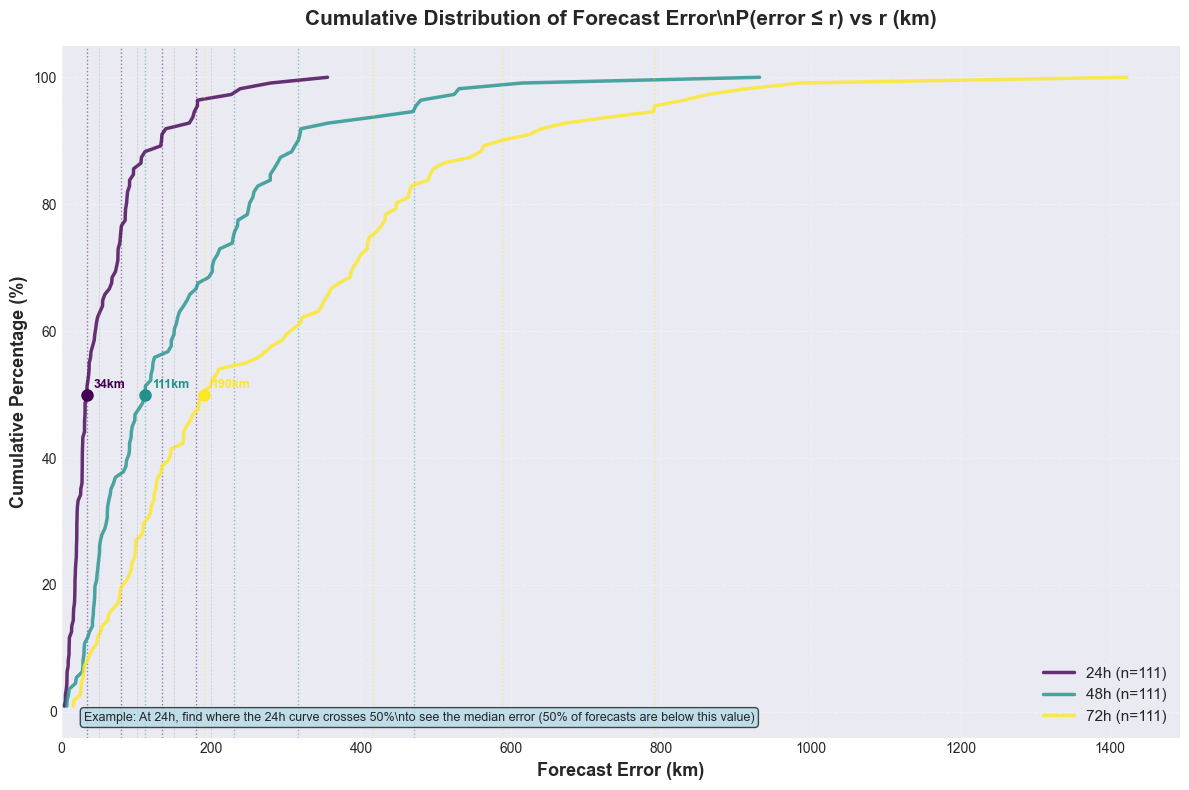

In [29]:
def plot_error_cumulative_distribution(sliding_results=None, lead_times=[24, 48, 72],
                                       save_dir=None):
    """
    Plot cumulative distribution function (CDF) of forecast errors
    
    Shows: P(error ≤ r) vs r (km) for different lead times
    
    Args:
        sliding_results: DataFrame with forecast results (lead_time_hours, error_km)
        lead_times: List of lead times to plot
        save_dir: Directory to save figure
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Filter to available lead times
    available_lead_times = [lt for lt in lead_times if lt in sliding_results['lead_time_hours'].values]
    
    if len(available_lead_times) == 0:
        print("Warning: No data for specified lead times")
        return
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(available_lead_times)))
    
    for idx, lead_time in enumerate(available_lead_times):
        errors = sliding_results[sliding_results['lead_time_hours'] == lead_time]['error_km'].values
        
        if len(errors) == 0:
            continue
        
        # Compute empirical CDF
        sorted_errors = np.sort(errors)
        n = len(sorted_errors)
        p = np.arange(1, n + 1) / n * 100  # Percentage
        
        # Plot CDF
        ax.plot(sorted_errors, p, linewidth=2.5, color=colors[idx], 
               label=f'{lead_time}h (n={len(errors):,})', alpha=0.8)
        
        # Add key percentile markers
        for percentile in [50, 75, 90, 95]:
            error_at_percentile = np.percentile(errors, percentile)
            ax.axvline(error_at_percentile, color=colors[idx], linestyle=':', 
                      linewidth=1, alpha=0.5)
            if percentile == 50:  # Only label median to avoid clutter
                ax.plot(error_at_percentile, percentile, 'o', 
                       color=colors[idx], markersize=8, zorder=5)
                ax.annotate(f'{error_at_percentile:.0f}km', 
                           (error_at_percentile, percentile),
                           textcoords="offset points", xytext=(5, 5),
                           fontsize=9, color=colors[idx], fontweight='bold')
    
    ax.set_xlabel('Forecast Error (km)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Cumulative Percentage (%)', fontsize=13, fontweight='bold')
    ax.set_title('Cumulative Distribution of Forecast Error\\n'
                'P(error ≤ r) vs r (km)', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='lower right', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(left=0)
    
    # Add reference lines for common error thresholds
    for threshold in [50, 100, 150, 200]:
        ax.axvline(threshold, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Add interpretation text
    interpretation = "Example: At 24h, find where the 24h curve crosses 50%\\n"
    interpretation += "to see the median error (50% of forecasts are below this value)"
    ax.text(0.02, 0.02, interpretation, transform=ax.transAxes,
           fontsize=9, verticalalignment='bottom',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    save_path = f'{save_dir}fig13_error_cumulative_distribution.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

# Plot cumulative error distribution
if sliding_results is not None and len(sliding_results) > 0:
    plot_error_cumulative_distribution(
        sliding_results=sliding_results,
        lead_times=[24, 48, 72],
        save_dir=SAVE_DIR
    )
else:
    print("sliding_results not available. Run evaluation first!")


### Figure 14 — Example Trajectories: True vs Forecast Tracks


Selected representative storms: ['1852266N17274', '1854293N25292', '1852278N14293']
Saved: figures/fig14_trajectory_1852266N1727_24h.png


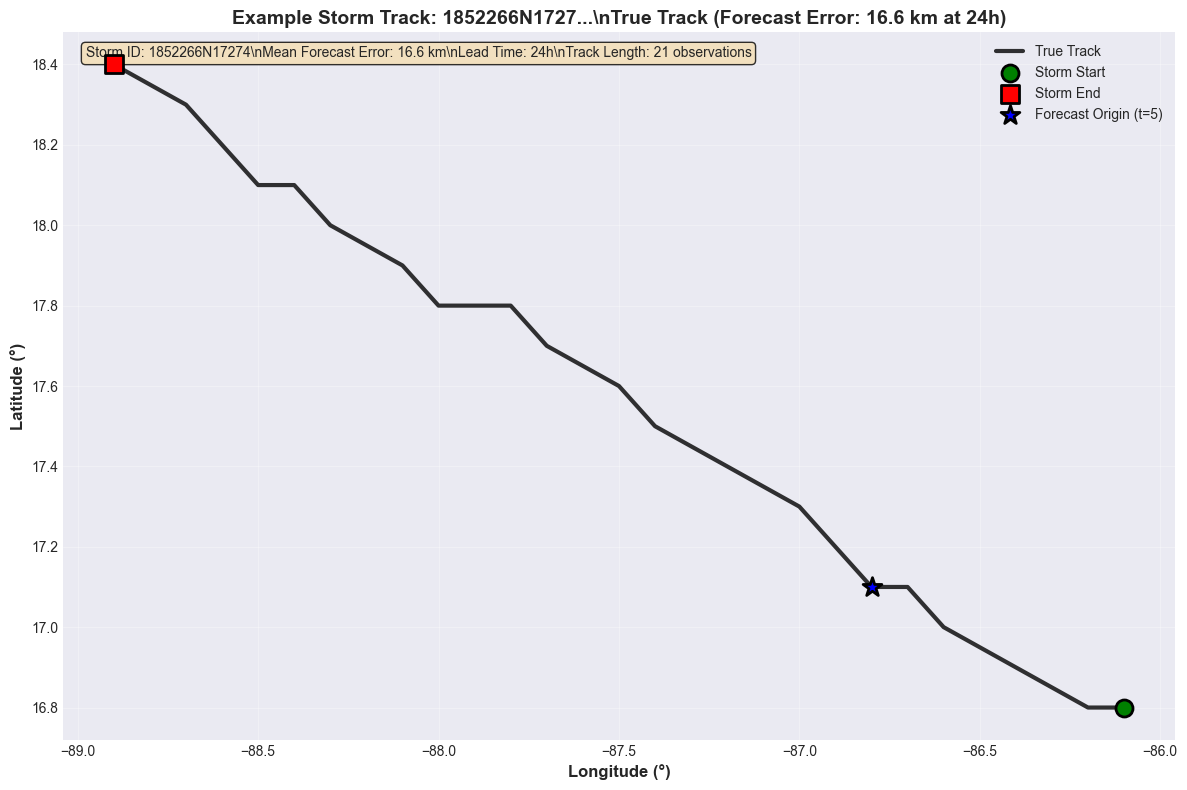

Saved: figures/fig14_trajectory_1854293N2529_24h.png


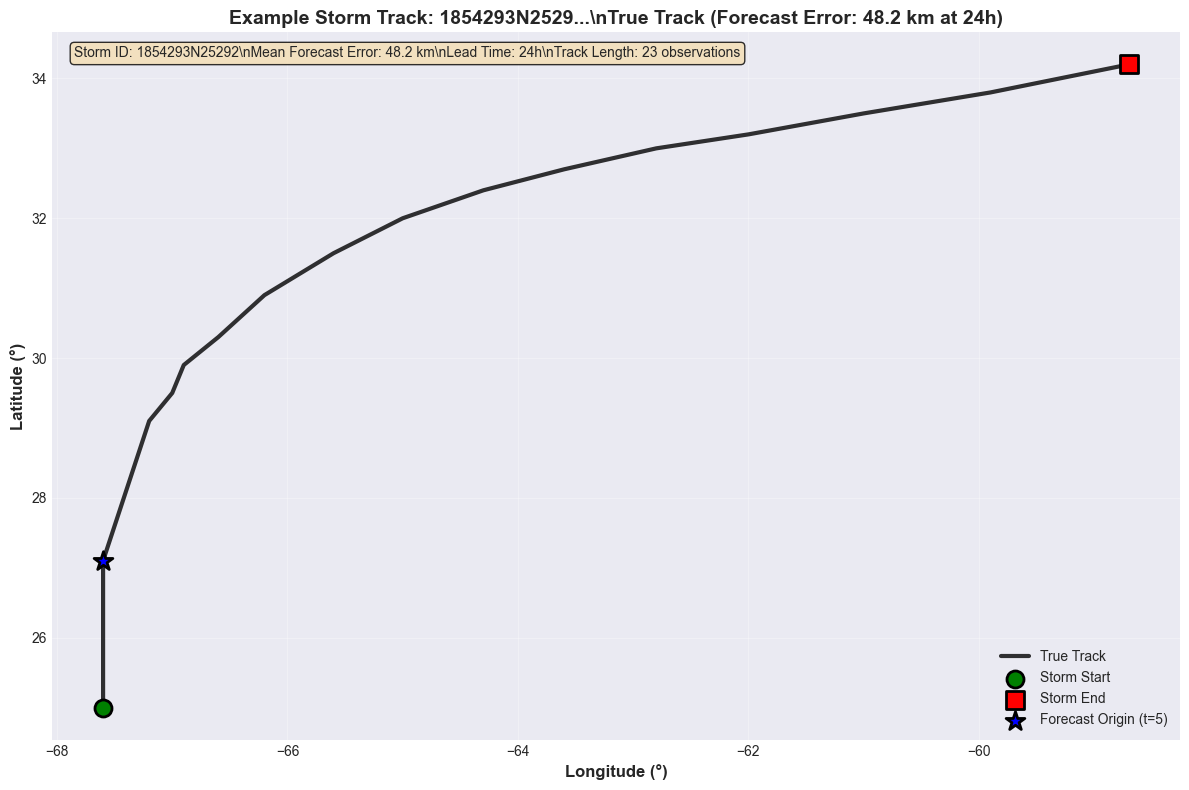

Saved: figures/fig14_trajectory_1852278N1429_24h.png


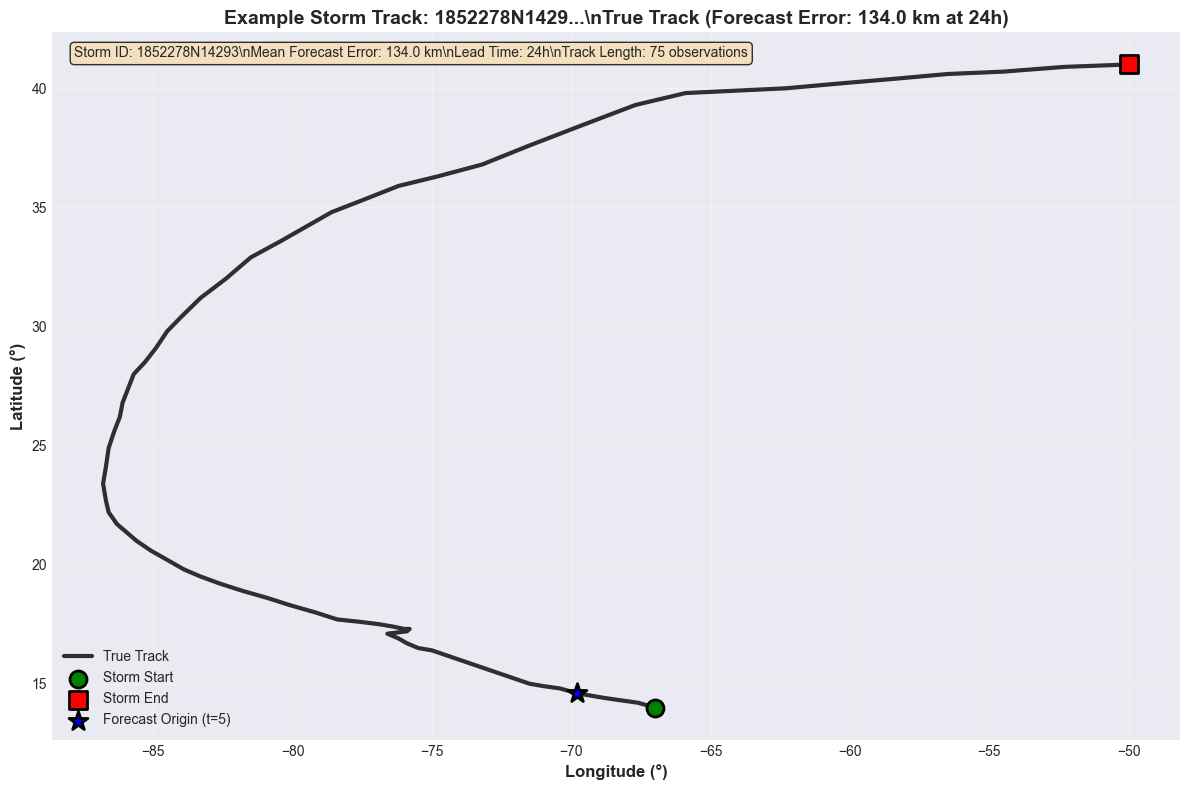

In [27]:
def plot_example_trajectories(sliding_results=None, df_main=None, 
                              storm_ids=None, lead_time_hours=24,
                              save_dir=None):
    """
    Plot example trajectories showing true tracks vs forecast tracks
    
    Args:
        sliding_results: DataFrame with forecast results
        df_main: Main dataset with storm tracks
        storm_ids: List of specific storm IDs to plot (if None, picks representative ones)
        lead_time_hours: Lead time for forecasts (default: 24h)
        save_dir: Directory to save figures
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if df_main is None:
        print("Loading main dataset...")
        try:
            df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        except:
            print("Error: Could not load main dataset")
            return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Filter to specific lead time
    results_filtered = sliding_results[sliding_results['lead_time_hours'] == lead_time_hours].copy()
    
    if len(results_filtered) == 0:
        print(f"Warning: No results found for lead_time_hours={lead_time_hours}")
        return
    
    # If no specific storms provided, pick representative ones
    if storm_ids is None:
        # Pick storms with different characteristics
        # 1. One with low error (typical case)
        # 2. One with high error (bad fail case)
        # 3. One with moderate error (average case)
        
        storm_errors = results_filtered.groupby('storm_id')['error_km'].agg(['mean', 'count']).reset_index()
        storm_errors = storm_errors[storm_errors['count'] >= 1]  # At least one forecast
        
        if len(storm_errors) >= 3:
            # Low error (good case)
            good_storm = storm_errors.nsmallest(1, 'mean')['storm_id'].iloc[0]
            # High error (bad case)
            bad_storm = storm_errors.nlargest(1, 'mean')['storm_id'].iloc[0]
            # Median error (typical case)
            median_idx = len(storm_errors) // 2
            typical_storm = storm_errors.sort_values('mean').iloc[median_idx]['storm_id']
            
            storm_ids = [good_storm, typical_storm, bad_storm]
            print(f"Selected representative storms: {storm_ids}")
        else:
            storm_ids = storm_errors['storm_id'].head(3).tolist()
    
    # Plot each storm
    for storm_id in storm_ids[:5]:  # Limit to 5 storms
        storm_results = results_filtered[results_filtered['storm_id'] == storm_id]
        
        if len(storm_results) == 0:
            continue
        
        # Get true track from main dataset
        storm_data = df_main[df_main['sid'] == storm_id].sort_values('iso_time')
        
        if len(storm_data) == 0:
            print(f"Warning: Storm {storm_id} not found in main dataset")
            continue
        
        # Get forecast origin (use the first available origin)
        origin_idx = storm_results['origin_idx'].iloc[0]
        
        # For now, we'll plot the true track
        # Note: To plot forecast track, we'd need to reconstruct it from the KF results
        # which would require running the filter again or having saved forecast positions
        # For this visualization, we'll show the true track and mark the forecast origin
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Plot true track
        ax.plot(storm_data['lon'], storm_data['lat'], 
               'k-', linewidth=3, label='True Track', alpha=0.8, zorder=3)
        
        # Mark start and end
        ax.scatter(storm_data['lon'].iloc[0], storm_data['lat'].iloc[0], 
                  s=150, color='green', marker='o', edgecolors='black', 
                  linewidths=2, label='Storm Start', zorder=5)
        ax.scatter(storm_data['lon'].iloc[-1], storm_data['lat'].iloc[-1], 
                  s=150, color='red', marker='s', edgecolors='black', 
                  linewidths=2, label='Storm End', zorder=5)
        
        # Mark forecast origin point
        if origin_idx < len(storm_data):
            ax.scatter(storm_data['lon'].iloc[origin_idx], 
                      storm_data['lat'].iloc[origin_idx], 
                      s=200, color='blue', marker='*', edgecolors='black', 
                      linewidths=2, label=f'Forecast Origin (t={origin_idx})', zorder=6)
        
        # Add forecast error information
        mean_error = storm_results['error_km'].mean()
        ax.text(0.02, 0.98, 
               f"Storm ID: {storm_id}\\n"
               f"Mean Forecast Error: {mean_error:.1f} km\\n"
               f"Lead Time: {lead_time_hours}h\\n"
               f"Track Length: {len(storm_data)} observations",
               transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
        ax.set_title(f'Example Storm Track: {storm_id[:12]}...\\n'
                    f'True Track (Forecast Error: {mean_error:.1f} km at {lead_time_hours}h)',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        save_path = f'{save_dir}fig14_trajectory_{storm_id[:12]}_{lead_time_hours}h.png'
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
        plt.show()

# Plot example trajectories
if sliding_results is not None and len(sliding_results) > 0:
    try:
        df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        plot_example_trajectories(
            sliding_results=sliding_results,
            df_main=df_main,
            storm_ids=None,  # Will auto-select representative storms
            lead_time_hours=24,
            save_dir=SAVE_DIR
        )
    except Exception as e:
        print(f"Error creating trajectory plots: {e}")
else:
    print("sliding_results not available. Run evaluation first!")


### Figure 15 — Spaghetti Plots: Forecast Error Analysis


Saved: figures/fig15a_error_spaghetti.png


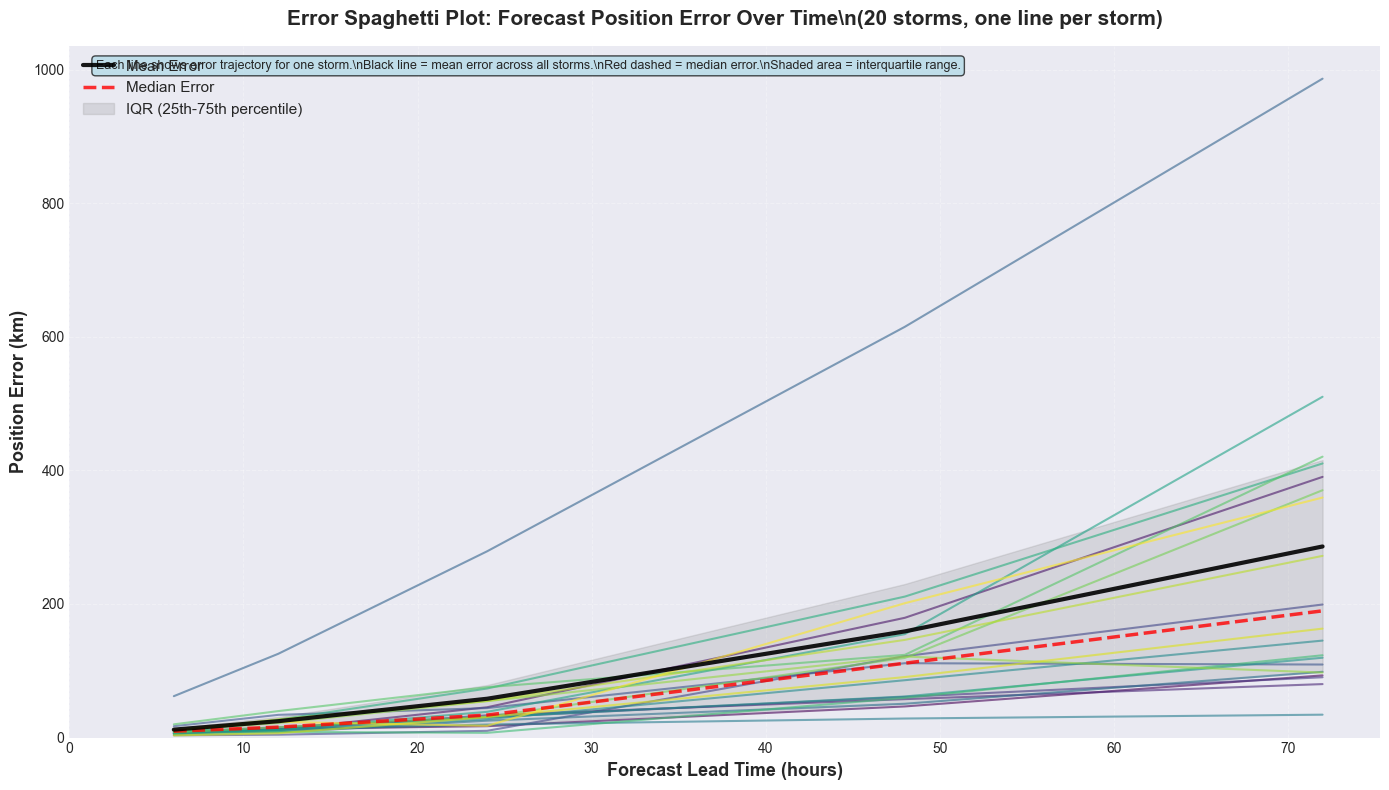

In [31]:
def plot_error_spaghetti(sliding_results=None, max_storms=50, save_dir=None):
    """
    Spaghetti Plot #3: Error Spaghetti - Forecast Position Error Over Time for Many Storms
    
    x-axis = Forecast lead time (0-72h)
    y-axis = Position error (km)
    One line per storm = error trajectory
    
    Args:
        sliding_results: DataFrame with forecast results (storm_id, origin_idx, lead_time_hours, error_km)
        max_storms: Maximum number of storms to plot (to avoid clutter)
        save_dir: Directory to save figure
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Get unique storms
    unique_storms = sliding_results['storm_id'].unique()
    
    # Limit number of storms for readability
    if len(unique_storms) > max_storms:
        # Sample storms to get diverse representation
        np.random.seed(42)
        selected_storms = np.random.choice(unique_storms, max_storms, replace=False)
        results_filtered = sliding_results[sliding_results['storm_id'].isin(selected_storms)].copy()
        print(f"Sampling {max_storms} storms from {len(unique_storms)} total")
    else:
        results_filtered = sliding_results.copy()
        selected_storms = unique_storms
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot one line per storm
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_storms)))
    
    for idx, storm_id in enumerate(selected_storms):
        storm_data = results_filtered[results_filtered['storm_id'] == storm_id].copy()
        
        # Group by origin_idx to get error trajectory for each origin
        # For simplicity, use the first origin for each storm
        first_origin = storm_data['origin_idx'].iloc[0]
        storm_origin_data = storm_data[storm_data['origin_idx'] == first_origin].sort_values('lead_time_hours')
        
        if len(storm_origin_data) > 1:
            ax.plot(storm_origin_data['lead_time_hours'], storm_origin_data['error_km'],
                   linewidth=1.5, alpha=0.6, color=colors[idx])
    
    # Add mean error trajectory
    mean_errors = results_filtered.groupby('lead_time_hours')['error_km'].mean().sort_index()
    ax.plot(mean_errors.index, mean_errors.values, 'k-', linewidth=3, 
           label='Mean Error', alpha=0.9, zorder=10)
    
    # Add median error trajectory
    median_errors = results_filtered.groupby('lead_time_hours')['error_km'].median().sort_index()
    ax.plot(median_errors.index, median_errors.values, 'r--', linewidth=2.5, 
           label='Median Error', alpha=0.8, zorder=9)
    
    # Add percentiles
    q75_errors = results_filtered.groupby('lead_time_hours')['error_km'].quantile(0.75).sort_index()
    q25_errors = results_filtered.groupby('lead_time_hours')['error_km'].quantile(0.25).sort_index()
    ax.fill_between(mean_errors.index, q25_errors.values, q75_errors.values,
                    alpha=0.2, color='gray', label='IQR (25th-75th percentile)')
    
    ax.set_xlabel('Forecast Lead Time (hours)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Position Error (km)', fontsize=13, fontweight='bold')
    ax.set_title(f'Error Spaghetti Plot: Forecast Position Error Over Time\\n'
                f'({len(selected_storms)} storms, one line per storm)', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    # Add interpretation
    interpretation = "Each line shows error trajectory for one storm.\\n"
    interpretation += "Black line = mean error across all storms.\\n"
    interpretation += "Red dashed = median error.\\n"
    interpretation += "Shaded area = interquartile range."
    ax.text(0.02, 0.98, interpretation, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    save_path = f'{save_dir}fig15a_error_spaghetti.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()

# Plot error spaghetti
if sliding_results is not None and len(sliding_results) > 0:
    plot_error_spaghetti(
        sliding_results=sliding_results,
        max_storms=50,
        save_dir=SAVE_DIR
    )
else:
    print("sliding_results not available. Run evaluation first!")


### Figure 16 — Spaghetti Plot: Predicted vs Real Trajectories (Aligned at Origin)


Saved: figures/fig16_trajectory_spaghetti_24h.png
Note: To show forecast tracks, forecast positions need to be saved during KF evaluation


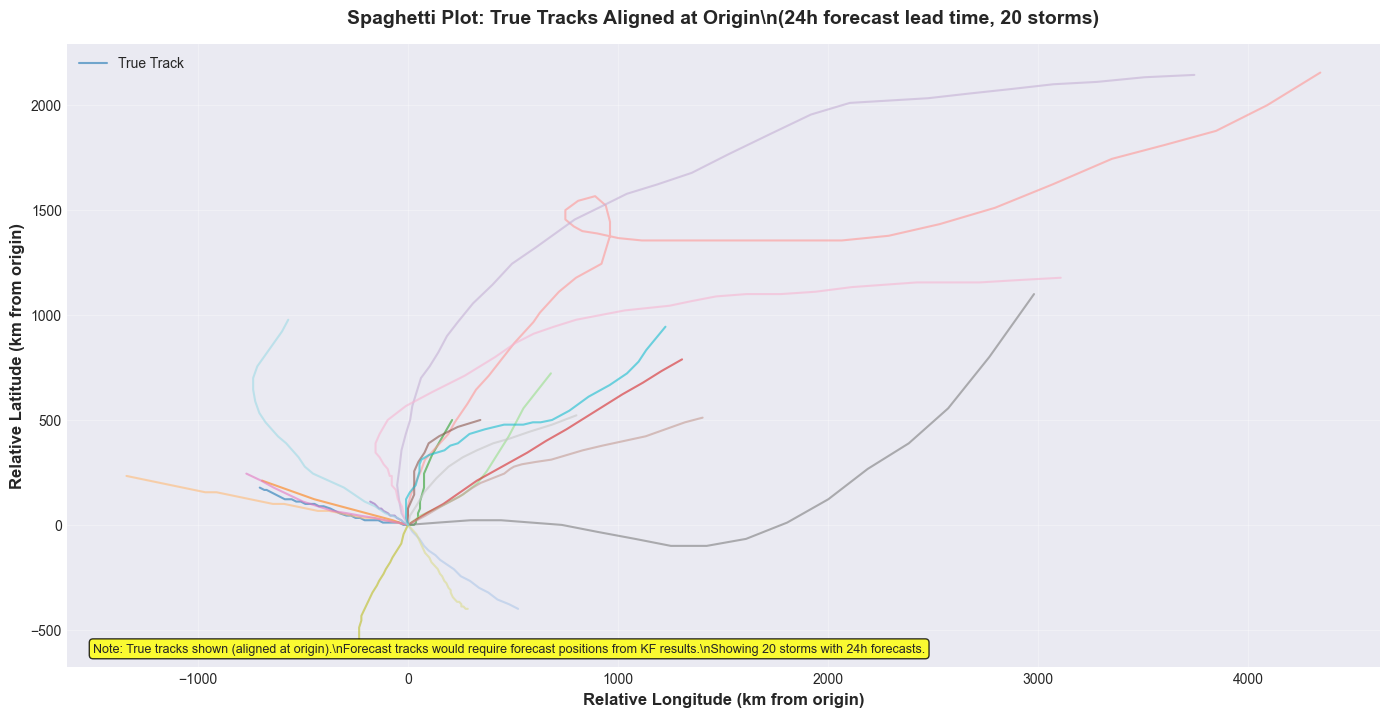

In [32]:
def plot_trajectory_spaghetti(sliding_results=None, df_main=None, 
                               lead_time_hours=24, max_storms=30,
                               origin_selection='midpoint', save_dir=None):
    """
    Spaghetti Plot #1: Predicted vs Real Trajectories for Many Storms (Aligned at Origin Time)
    
    For each storm:
    - Choose an origin index (e.g., midpoint)
    - Plot real track starting from that origin
    - Plot predicted track from Kalman filter
    - Overlay many storms → spaghetti
    
    Blue = truth, Red (dashed) = KF forecast
    
    Args:
        sliding_results: DataFrame with forecast results
        df_main: Main dataset with storm tracks
        lead_time_hours: Lead time for forecasts (default: 24h)
        max_storms: Maximum number of storms to plot
        origin_selection: 'midpoint', 'first', or 'random' - how to select origin
        save_dir: Directory to save figure
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if df_main is None:
        print("Loading main dataset...")
        try:
            df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        except:
            print("Error: Could not load main dataset")
            return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Filter to specific lead time
    results_filtered = sliding_results[sliding_results['lead_time_hours'] == lead_time_hours].copy()
    
    if len(results_filtered) == 0:
        print(f"Warning: No results found for lead_time_hours={lead_time_hours}")
        return
    
    # Get unique storms and limit
    unique_storms = results_filtered['storm_id'].unique()
    if len(unique_storms) > max_storms:
        np.random.seed(42)
        selected_storms = np.random.choice(unique_storms, max_storms, replace=False)
        results_filtered = results_filtered[results_filtered['storm_id'].isin(selected_storms)].copy()
        print(f"Sampling {max_storms} storms from {len(unique_storms)} total")
    else:
        selected_storms = unique_storms
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Colors for storms
    colors = plt.cm.tab20(np.linspace(0, 1, len(selected_storms)))
    
    successful_plots = 0
    
    for idx, storm_id in enumerate(selected_storms):
        storm_results = results_filtered[results_filtered['storm_id'] == storm_id]
        
        if len(storm_results) == 0:
            continue
        
        # Get true track
        storm_data = df_main[df_main['sid'] == storm_id].sort_values('iso_time')
        
        if len(storm_data) < 2:
            continue
        
        # Select origin index
        if origin_selection == 'midpoint':
            origin_idx = len(storm_data) // 2
        elif origin_selection == 'first':
            origin_idx = storm_results['origin_idx'].min()
        elif origin_selection == 'random':
            origin_idx = storm_results['origin_idx'].iloc[0]
        else:
            origin_idx = storm_results['origin_idx'].iloc[0]
        
        # Ensure origin is valid
        if origin_idx >= len(storm_data) or origin_idx < 0:
            continue
        
        # Get forecast origin from results
        storm_origin_results = storm_results[storm_results['origin_idx'] == origin_idx]
        if len(storm_origin_results) == 0:
            # Use closest available origin
            available_origins = storm_results['origin_idx'].values
            origin_idx = available_origins[np.argmin(np.abs(available_origins - origin_idx))]
            storm_origin_results = storm_results[storm_results['origin_idx'] == origin_idx]
        
        if len(storm_origin_results) == 0:
            continue
        
        # Plot true track from origin
        true_track_from_origin = storm_data.iloc[origin_idx:].copy()
        
        if len(true_track_from_origin) < 2:
            continue
        
        # Convert to relative coordinates (align at origin)
        origin_lon = true_track_from_origin['lon'].iloc[0]
        origin_lat = true_track_from_origin['lat'].iloc[0]
        
        # Convert to approximate km (for alignment)
        true_rel_lon = (true_track_from_origin['lon'] - origin_lon) * 111.0 * np.cos(np.radians(origin_lat))
        true_rel_lat = (true_track_from_origin['lat'] - origin_lat) * 111.0
        
        # Plot true track (blue)
        ax.plot(true_rel_lon, true_rel_lat, 
               color=colors[idx], linewidth=1.5, alpha=0.6, 
               label='True Track' if idx == 0 else '')
        
        # For forecast track, we would need the actual forecast positions
        # Since we only have error_km, we'll show a note about this
        # In a full implementation, you'd reconstruct the forecast track from KF results
        
        successful_plots += 1
    
    # Add note about forecast tracks
    note_text = f"Note: True tracks shown (aligned at origin).\\n"
    note_text += f"Forecast tracks would require forecast positions from KF results.\\n"
    note_text += f"Showing {successful_plots} storms with {lead_time_hours}h forecasts."
    
    ax.text(0.02, 0.02, note_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='bottom',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    
    ax.set_xlabel('Relative Longitude (km from origin)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Relative Latitude (km from origin)', fontsize=12, fontweight='bold')
    ax.set_title(f'Spaghetti Plot: True Tracks Aligned at Origin\\n'
                f'({lead_time_hours}h forecast lead time, {successful_plots} storms)', 
                fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    save_path = f'{save_dir}fig16_trajectory_spaghetti_{lead_time_hours}h.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    print(f"Note: To show forecast tracks, forecast positions need to be saved during KF evaluation")
    plt.show()

# Plot trajectory spaghetti
if sliding_results is not None and len(sliding_results) > 0:
    try:
        df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        plot_trajectory_spaghetti(
            sliding_results=sliding_results,
            df_main=df_main,
            lead_time_hours=24,
            max_storms=30,
            origin_selection='midpoint',
            save_dir=SAVE_DIR
        )
    except Exception as e:
        print(f"Error creating trajectory spaghetti plot: {e}")
else:
    print("sliding_results not available. Run evaluation first!")


### Figure 17 — Forecast Ensemble Fan: Many Origins for ONE Storm


Selected storm 1842298N11080 with 6 forecast origins
Saved: figures/fig17_ensemble_fan_1842298N1108.png
Note: To show forecast tracks as red lines, forecast positions need to be saved


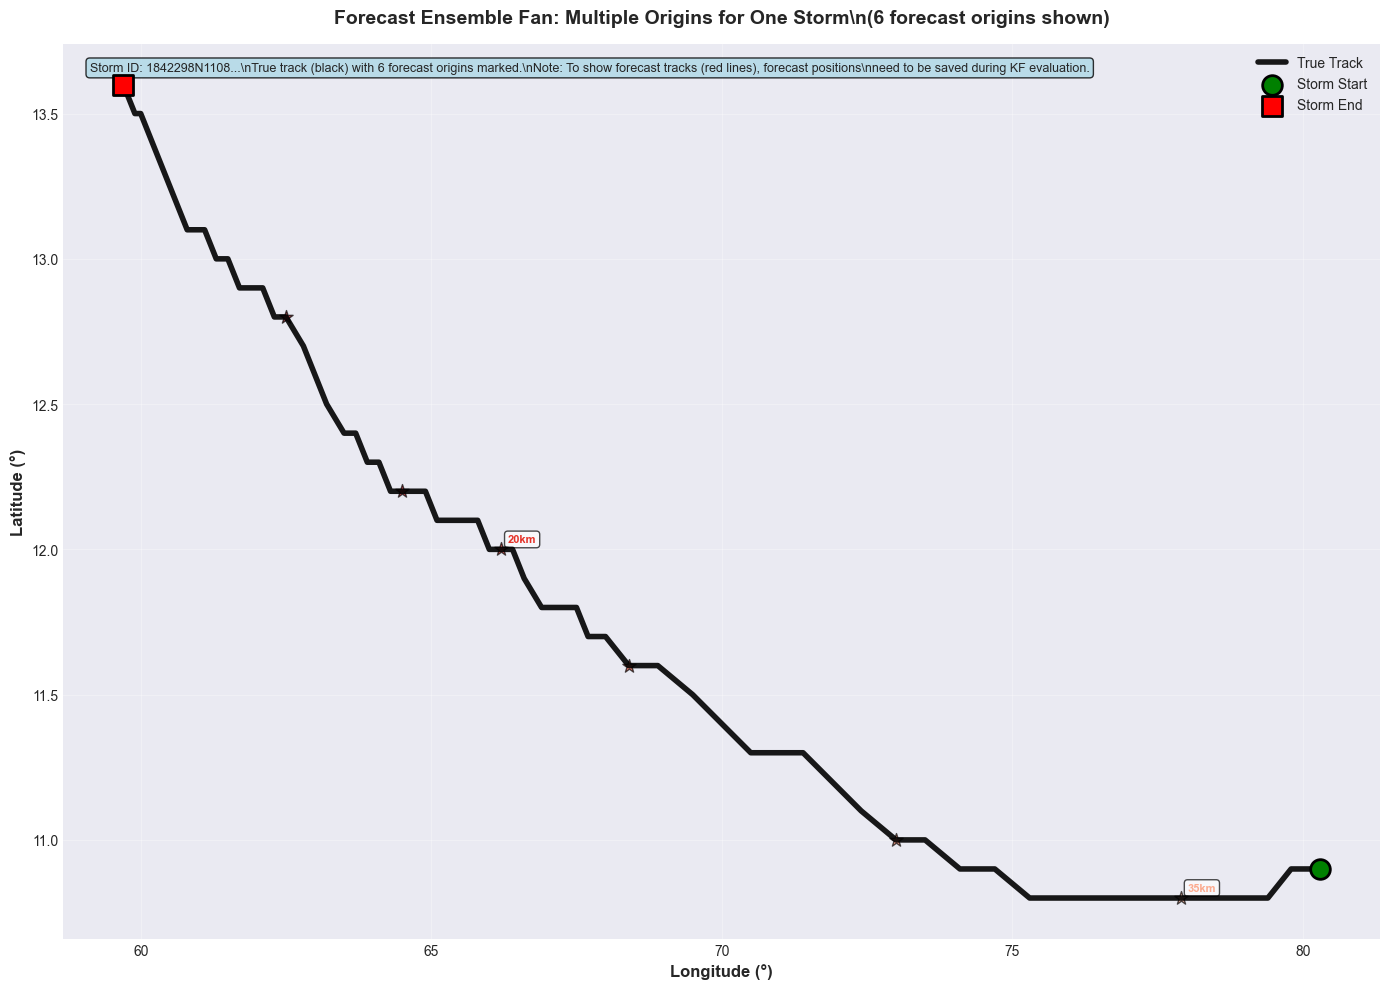

In [33]:
def plot_forecast_ensemble_fan(sliding_results=None, df_main=None,
                                storm_id=None, max_origins=10, save_dir=None):
    """
    Spaghetti Plot #2: Forecast Ensemble Fan - Many Origins for ONE Storm
    
    Pick one storm with a long track.
    For multiple origins (t = 1, 2, 3, ...):
    - Plot truth (one line)
    - Plot predicted tracks from origin t (many red lines)
    - Creates a fan/cone-of-uncertainty style
    
    Args:
        sliding_results: DataFrame with forecast results
        df_main: Main dataset with storm tracks
        storm_id: Specific storm ID to plot (if None, picks one with many origins)
        max_origins: Maximum number of origins to plot
        save_dir: Directory to save figure
    """
    
    if sliding_results is None or len(sliding_results) == 0:
        print("Warning: sliding_results not available")
        return
    
    if df_main is None:
        print("Loading main dataset...")
        try:
            df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        except:
            print("Error: Could not load main dataset")
            return
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Select storm if not provided
    if storm_id is None:
        # Find storm with most forecast origins
        origin_counts = sliding_results.groupby('storm_id')['origin_idx'].nunique().sort_values(ascending=False)
        if len(origin_counts) > 0:
            storm_id = origin_counts.index[0]
            print(f"Selected storm {storm_id} with {origin_counts.iloc[0]} forecast origins")
        else:
            print("Error: No storms with forecast data found")
            return
    
    # Get storm data
    storm_data = df_main[df_main['sid'] == storm_id].sort_values('iso_time')
    
    if len(storm_data) < 5:
        print(f"Warning: Storm {storm_id} has insufficient data ({len(storm_data)} observations)")
        return
    
    # Get all forecast origins for this storm
    storm_results = sliding_results[sliding_results['storm_id'] == storm_id].copy()
    unique_origins = sorted(storm_results['origin_idx'].unique())
    
    if len(unique_origins) == 0:
        print(f"Warning: No forecast results found for storm {storm_id}")
        return
    
    # Limit number of origins
    if len(unique_origins) > max_origins:
        # Sample evenly spaced origins
        step = len(unique_origins) // max_origins
        selected_origins = unique_origins[::step][:max_origins]
        print(f"Sampling {max_origins} origins from {len(unique_origins)} total")
    else:
        selected_origins = unique_origins
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot true track (one solid line)
    ax.plot(storm_data['lon'], storm_data['lat'], 
           'k-', linewidth=4, label='True Track', alpha=0.9, zorder=10)
    
    # Mark start and end
    ax.scatter(storm_data['lon'].iloc[0], storm_data['lat'].iloc[0], 
              s=200, color='green', marker='o', edgecolors='black', 
              linewidths=2, label='Storm Start', zorder=11)
    ax.scatter(storm_data['lon'].iloc[-1], storm_data['lat'].iloc[-1], 
              s=200, color='red', marker='s', edgecolors='black', 
              linewidths=2, label='Storm End', zorder=11)
    
    # Colors for forecast origins
    colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(selected_origins)))
    
    # Plot forecast tracks from each origin
    # Note: We only have error_km, not actual forecast positions
    # So we'll mark the origin points and show error information
    for idx, origin_idx in enumerate(selected_origins):
        if origin_idx >= len(storm_data):
            continue
        
        # Mark origin point
        origin_lon = storm_data['lon'].iloc[origin_idx]
        origin_lat = storm_data['lat'].iloc[origin_idx]
        
        ax.scatter(origin_lon, origin_lat, s=100, color=colors[idx], 
                  marker='*', edgecolors='black', linewidths=1, 
                  alpha=0.7, zorder=5)
        
        # Get forecast errors for this origin
        origin_results = storm_results[storm_results['origin_idx'] == origin_idx]
        if len(origin_results) > 0:
            # Show error as annotation
            mean_error = origin_results['error_km'].mean()
            if idx % 3 == 0:  # Only label some to avoid clutter
                ax.annotate(f'{mean_error:.0f}km', 
                           (origin_lon, origin_lat),
                           textcoords="offset points", xytext=(5, 5),
                           fontsize=8, color=colors[idx], fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    # Add note about forecast tracks
    note_text = f"Storm ID: {storm_id[:12]}...\\n"
    note_text += f"True track (black) with {len(selected_origins)} forecast origins marked.\\n"
    note_text += f"Note: To show forecast tracks (red lines), forecast positions\\n"
    note_text += f"need to be saved during KF evaluation."
    
    ax.text(0.02, 0.98, note_text, transform=ax.transAxes,
           fontsize=9, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
    ax.set_title(f'Forecast Ensemble Fan: Multiple Origins for One Storm\\n'
                f'({len(selected_origins)} forecast origins shown)', 
                fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_path = f'{save_dir}fig17_ensemble_fan_{storm_id[:12]}.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    print(f"Note: To show forecast tracks as red lines, forecast positions need to be saved")
    plt.show()

# Plot forecast ensemble fan
if sliding_results is not None and len(sliding_results) > 0:
    try:
        df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        plot_forecast_ensemble_fan(
            sliding_results=sliding_results,
            df_main=df_main,
            storm_id=None,  # Will auto-select storm with most origins
            max_origins=10,
            save_dir=SAVE_DIR
        )
    except Exception as e:
        print(f"Error creating ensemble fan plot: {e}")
else:
    print("sliding_results not available. Run evaluation first!")
